In [1]:
from   astropy.table         import Table
from astropy.coordinates     import SkyCoord
import pylab                 as pl
import numpy                 as np
import pandas                as pd
import os
from   astropy.io            import fits
from   glob                  import glob
from   desitarget.targetmask import desi_mask, bgs_mask, mws_mask
from   scipy.spatial         import KDTree
import desispec.io
from matplotlib.ticker import FormatStrFormatter

In [2]:
from io import BytesIO 
from io import StringIO
import requests
import numpy as np 
from PIL import Image

def load_image(url): 
    res = requests.get(url)
    img_arr = np.array(Image.open(BytesIO(res.content)))
    return img_arr

In [3]:
params = {'legend.fontsize': '20',
          'figure.figsize': (7, 7),
          'figure.facecolor': 'white',
         'axes.labelsize': '20',
         'axes.titlesize':'20',
         'figure.titlesize':'20',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20',
         'axes.labelpad' : '20'}
pl.rcParams.update(params)

In [4]:
data = Table.read('./data/gama_gold_ddp.fits')

In [5]:
# data.keys()

In [6]:
#- Read the GAMA Data
ra_gama   = data['RA']
dec_gama  = data['DEC']
z_gama    = data['ZGAMA']
gmag_gama    = data['GMAG_DRED_SDSS']

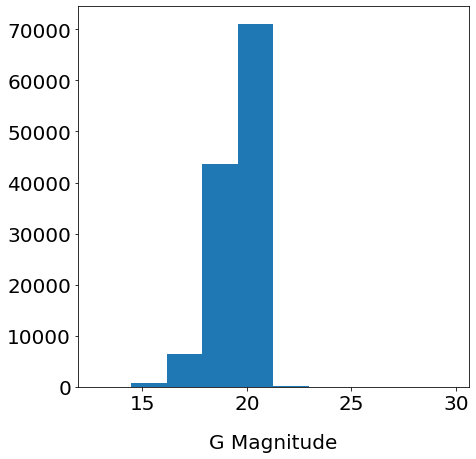

In [7]:
#- G Magnitude rom GAMA
_ = pl.hist(gmag_gama)
pl.xlabel('G Magnitude')
pl.show()

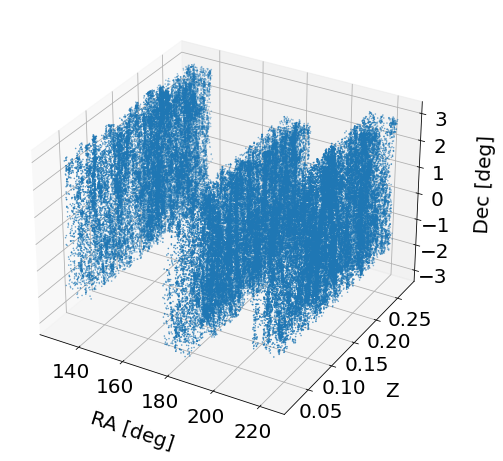

In [10]:
#- Plot RA Dec Z
fig = pl.figure(figsize=(8,8))
ax = pl.axes(projection='3d')
ax.scatter(ra_gama, z_gama, dec_gama, s=0.3)
ax.set_xlabel('RA [deg]')
ax.set_zlabel('Dec [deg]')
ax.set_ylabel('Z ')
pl.show()

In [12]:
#- Load the DES bright (BGS galaxies)
flavour = 'bright'
#flavour = 'dark'
df_des = pd.DataFrame()

# df_des = df_des.append(pd.read_csv(f'./data/DR9_BGS{flavour.upper()}_everest_sv1_data.csv'))
# df_des = df_des.append(pd.read_csv(f'./data/DR9_BGS{flavour.upper()}_everest_sv3_data.csv'))
# df_des = df_des.append(pd.read_csv(f'./data/DR9_BGS{flavour.upper()}_fuji_sv1_data.csv'))
df_des = df_des.append(pd.read_csv(f'./data/DR9_BGS{flavour.upper()}_fuji_sv3_data.csv'))
# df_des = df_des.append(pd.read_csv(f'./data/DR9_BGS{flavour.upper()}_guadalupe_main_data.csv'))
df_des = df_des.drop_duplicates()

In [13]:
#- Match TARGETID from DES and DESI to get Z_DES
df_des

ID          RA        DEC         Z      TARGETID        E1  \
0            0.0  217.807561  33.485444  0.156276  3.963295e+16 -0.097565   
1            1.0  217.647896  33.494584  0.135927  3.963295e+16 -0.487728   
2            2.0  217.536709  33.368542 -0.001996  3.963295e+16  0.340379   
3            3.0  217.788134  33.320160  0.099612  3.963295e+16 -0.052081   
4            4.0  217.662694  33.279517  0.195817  3.963295e+16 -0.253607   
...          ...         ...        ...       ...           ...       ...   
188920  188920.0         NaN        NaN       NaN  3.963342e+16       NaN   
188921  188921.0         NaN        NaN       NaN  3.963342e+16       NaN   
188922  188922.0         NaN        NaN       NaN  3.963342e+16       NaN   
188923  188923.0         NaN        NaN       NaN  3.963342e+16       NaN   
188924  188924.0         NaN        NaN       NaN  3.963342e+16       NaN   

              E2         E         R        BA        PHI       GMAG  
0      -0.234101  0.253618  1.048463  0.595382  33.687717  20.147871  
1       0.109514  0.499872  1.057559  0.333447  -6.327614  20.196304  
2       0.102842  0.355576  0.957263  0.475387 -81.594185  20.381155  
3      -0.004794  0.052301  1.687296  0.900597   2.629547  19.156443  
4      -0.201801  0.324099  0.513650  0.510462  19.255043  20.164797  
...          ...       ...       ...       ...        ...        ...  
188920       NaN       NaN  1.527158       NaN        NaN        NaN  
188921       NaN       NaN  0.959964       NaN        NaN        NaN  
188922       NaN       NaN  1.265679       NaN        NaN        NaN  
188923       NaN       NaN  0.595810       NaN        NaN        NaN  
188924       NaN       NaN  2.461631       NaN        NaN        NaN  

[188925 rows x 12 columns]

In [15]:
ii_ellipticity = (df_des['E'] > 0.2) & (df_des['E'] < 0.6)
df_des = df_des[ii_ellipticity]

In [16]:
#- Load Final RA DEC Z GMAG from DES
ra_des  = df_des['RA']
dec_des = df_des['DEC']
gmag_des = df_des['GMAG']
z_des = df_des['Z']

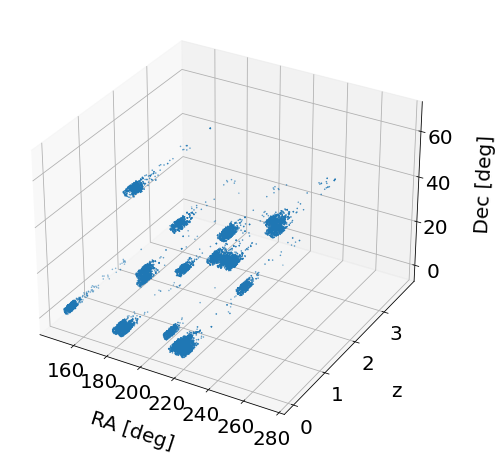

In [17]:
#- Plot RA Dec Z from DES
fig = pl.figure(figsize=(8,8))
ax = pl.axes(projection='3d')
ax.scatter(ra_des, z_des, dec_des, s=0.3)
ax.set_xlabel('RA [deg]')
ax.set_zlabel('Dec [deg]')
ax.set_ylabel('z')
pl.show()

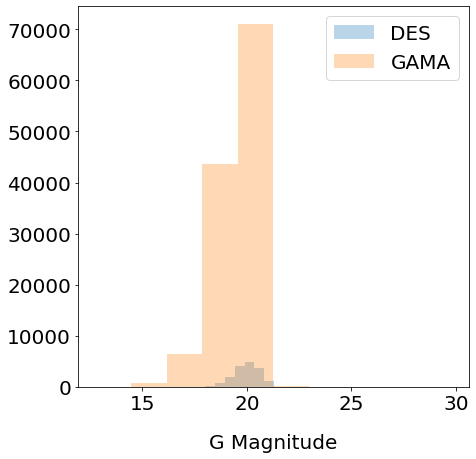

In [18]:
_ = pl.hist(gmag_des, label='DES', alpha=0.3)
_ = pl.hist(gmag_gama, label='GAMA', alpha=0.3)
pl.xlabel('G Magnitude')
pl.legend()

In [19]:
len(gmag_des), len(gmag_gama)
ii_ddp1 = data['DDP'][:,0] == 1
sum(ii_ddp1), len(ii_ddp1)

(50872, 121975)

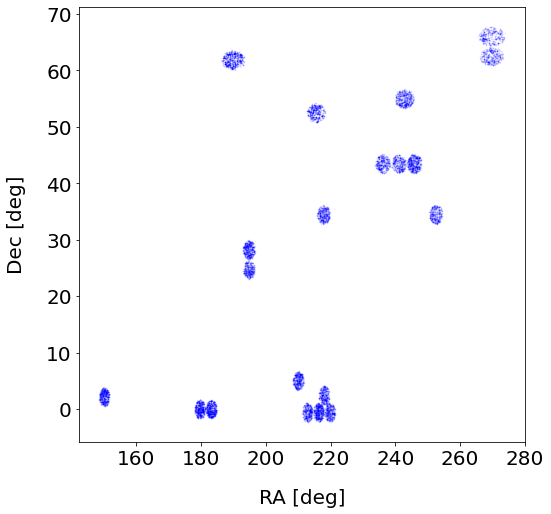

In [20]:
#- Plot the match RA Dec from GAMA region in the DES catalog
fig = pl.figure(figsize=(8,8))
# pl.scatter(ra_gama[ii_ddp1], dec_gama[ii_ddp1], s=0.3, c='r')
pl.scatter(ra_des,  dec_des,  s=0.3, c='b', alpha=0.1)
pl.xlabel('RA [deg]')
pl.ylabel('Dec [deg]')
pl.show()

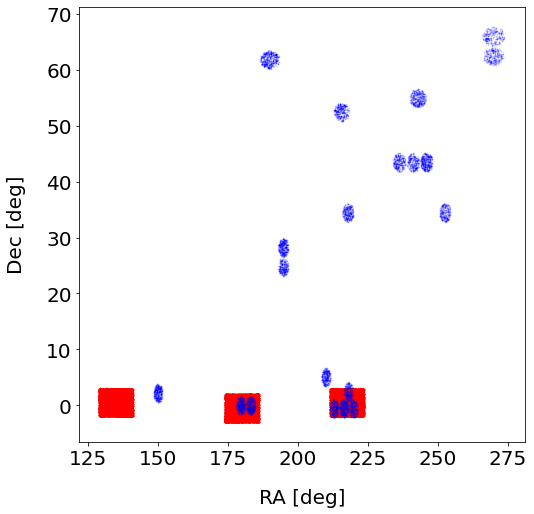

In [21]:
#- Plot the match RA Dec from GAMA region in the DES catalog
fig = pl.figure(figsize=(8,8))
pl.scatter(ra_gama[ii_ddp1], dec_gama[ii_ddp1], s=0.3, c='r')
pl.scatter(ra_des,  dec_des,  s=0.3, c='b', alpha=0.1)
pl.xlabel('RA [deg]')
pl.ylabel('Dec [deg]')
pl.show()

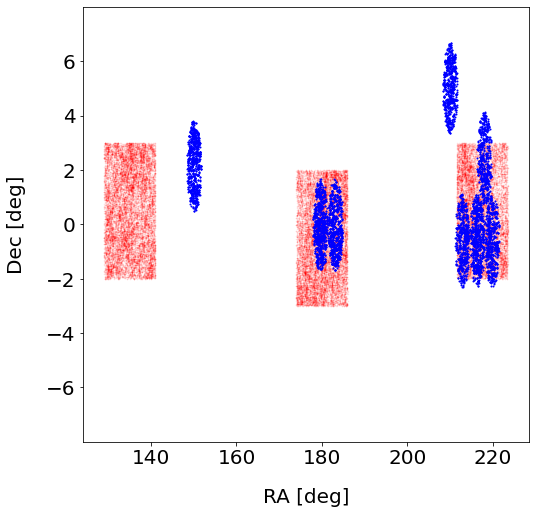

In [22]:
#- RA Dec Match zoom in
fig = pl.figure(figsize=(8,8))
pl.scatter(ra_gama[ii_ddp1], dec_gama[ii_ddp1], s=0.3, c='r', alpha=0.1)
pl.scatter(ra_des,  dec_des,  s=1, c='b')
pl.xlim(min(ra_gama)-5,max(ra_gama)+5)
pl.ylim(min(dec_gama)-5,max(dec_gama)+5)
pl.xlabel('RA [deg]')
pl.ylabel('Dec [deg]')
pl.show()

In [23]:
#- Get the FIELDs
ra_gama_g9   = data['RA'][data['FIELD']=='G9']
dec_gama_g9  = data['DEC'][data['FIELD']=='G9']
ra_gama_g12  = data['RA'][data['FIELD']=='G12']
dec_gama_g12 = data['DEC'][data['FIELD']=='G12']
ra_gama_g15  = data['RA'][data['FIELD']=='G15']
dec_gama_g15 = data['DEC'][data['FIELD']=='G15']

In [24]:
#- Count the number of DESI objects matched with the GAMA fields
N_DES_G9 = sum( (df_des['RA'] > min(ra_gama_g9)) & (df_des['RA'] < max(ra_gama_g9)) & (df_des['DEC'] > min(dec_gama_g9)) & (df_des['DEC'] < max(dec_gama_g9)) )
N_DES_G12 = sum( (df_des['RA'] > min(ra_gama_g12)) & (df_des['RA'] < max(ra_gama_g12)) & (df_des['DEC'] > min(dec_gama_g12)) & (df_des['DEC'] < max(dec_gama_g12)) )
N_DES_G15 = sum( (df_des['RA'] > min(ra_gama_g15)) & (df_des['RA'] < max(ra_gama_g15)) & (df_des['DEC'] > min(dec_gama_g15)) & (df_des['DEC'] < max(dec_gama_g15)) )

In [25]:
print(N_DES_G9, N_DES_G12, N_DES_G15)
print(len(dec_gama_g9), len(dec_gama_g12), len(dec_gama_g15))
print(N_DES_G9/len(dec_gama_g9)*100, N_DES_G12/len(dec_gama_g12)*100, N_DES_G15/len(dec_gama_g15)*100)

0 2181 2968
37192 43605 41178
0.0 5.00171998624011 7.207732284229443


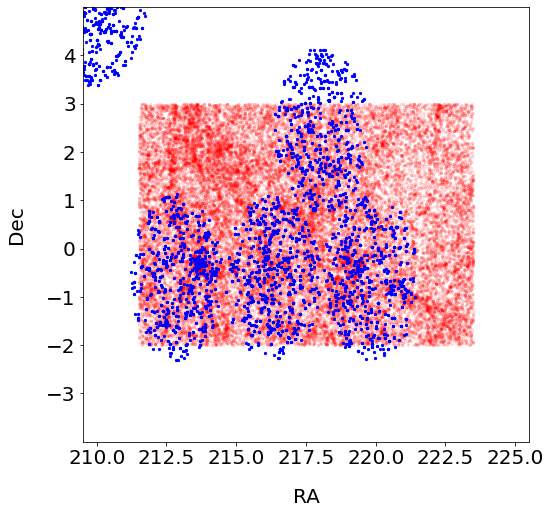

In [26]:
#- RA Dec Match zoom in more
fig = pl.figure(figsize=(8,8))
pl.scatter(np.around(ra_gama_g15, 3), np.around(dec_gama_g15, 3), s=5, c='r', alpha=0.1)
pl.scatter(np.around(ra_des,  3), np.around(dec_des,  3), s=5, c='b')
pl.xlim(min(ra_gama_g15)-2, max(ra_gama_g15)+2)
pl.ylim(min(dec_gama_g15)-2, max(dec_gama_g15)+2)
pl.xlabel('RA')
pl.ylabel('Dec')
pl.show()

In [27]:
#- Load trees for des data to find k=1 nearest using ra,dec,z
tree = KDTree(np.c_[ra_des, dec_des, z_des])

In [28]:
# Find the 1-NN for each GAMA RA Dec
distances, indices = tree.query(np.c_[ra_gama, dec_gama, z_gama], k=1)

In [29]:
# len(indices), len(ra_gama)

Text(0.5, 0, 'Distance [Mpc]')

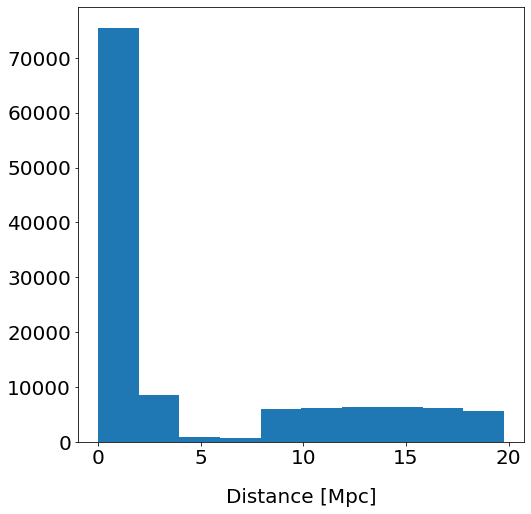

In [35]:
fig = pl.figure(figsize=(8,8))
_ = pl.hist(distances)
pl.xlabel('Distance [Mpc]')

In [36]:
np.shape(indices), indices[0]

((121975,), 9470)

In [37]:
# Ordening the DES entries using the IDs get for indices
df_des.iloc[indices]

ID          RA       DEC         Z      TARGETID        E1  \
19584  19584.0  148.444805  2.038870  0.161585  3.962784e+16 -0.349556   
14806  14806.0  177.992857 -0.102501  0.135537  3.962779e+16  0.391461   
24215  24215.0  215.832765  0.211291  0.223046  3.962779e+16 -0.109456   
16531  16531.0  217.212802  0.614906  0.104065  3.962780e+16 -0.145950   
23996  23996.0  148.485361  1.610832  0.096351  3.962782e+16 -0.201212   
...        ...         ...       ...       ...           ...       ...   
14258  14258.0  220.604058  0.388576  0.169972  3.962780e+16 -0.348787   
16259  16259.0  216.263466  0.261872  0.134595  3.962779e+16 -0.242840   
19584  19584.0  148.444805  2.038870  0.161585  3.962784e+16 -0.349556   
31516  31516.0  212.492630  1.067673  0.179067  3.962781e+16  0.133282   
5404    5404.0  178.055574  0.562942  0.196142  3.962780e+16 -0.188840   

             E2         E          R        BA        PHI       GMAG  
19584 -0.074572  0.357422   0.672549  0.473381   6.021301  20.371277  
14806  0.041586  0.393663   1.662514  0.435067 -86.968018  20.895863  
24215 -0.237149  0.261190   1.303114  0.585804  32.612167  19.916380  
16531  0.209651  0.255450   1.586684  0.593054 -27.577980  20.103724  
23996 -0.066301  0.211854   2.842250  0.650364   9.118782  19.803915  
...         ...       ...        ...       ...        ...        ...  
14258 -0.334403  0.483196   0.655149  0.348440  21.896950  20.657768  
16259  0.154832  0.288001   3.187913  0.552794 -16.260597  19.483662  
19584 -0.074572  0.357422   0.672549  0.473381   6.021301  20.371277  
31516 -0.215507  0.253391   0.387590  0.595671  60.867500  20.586672  
5404  -0.268566  0.328311  13.624000  0.505671  27.443710  20.290936  

[121975 rows x 12 columns]

In [38]:
# df_match = pd.DataFrame( df_des.iloc[indices], data )
# df_match

In [39]:
len(data), len(df_des.iloc[indices])

(121975, 121975)

In [40]:
data_match = data.copy()

In [41]:
df_des.keys()

Index(['ID', 'RA', 'DEC', 'Z', 'TARGETID', 'E1', 'E2', 'E', 'R', 'BA', 'PHI',
       'GMAG'],
      dtype='object')

In [42]:
# Match GAMA and DES
data_match['RA_DES']              = df_des['RA'].iloc[indices]
data_match['DEC_DES']             = df_des['DEC'].iloc[indices]
data_match['Z_DES']               = df_des['Z'].iloc[indices]
data_match['TARGETID_DES']        = np.array(df_des['TARGETID'].iloc[indices], dtype=int)
data_match['E1_DES']              = df_des['E1'].iloc[indices]
data_match['E2_DES']              = df_des['E2'].iloc[indices]
data_match['E_DES']               = df_des['E'].iloc[indices]
data_match['R_DES']               = df_des['R'].iloc[indices]
data_match['BA_DES']              = df_des['BA'].iloc[indices]
data_match['PHI_DES']             = df_des['PHI'].iloc[indices]
data_match['GMAG_DES']            = df_des['GMAG'].iloc[indices]
data_match['DISTANCE_MATCH_DES']  = distances

In [43]:
data_match.keys()

['CATAID',
 'OBJID',
 'RA',
 'DEC',
 'R_PETRO',
 'ZGAMA',
 'NQ',
 'SPECID',
 'SURVEY_CLASS',
 'UMAG_DRED_SDSS',
 'GMAG_DRED_SDSS',
 'RMAG_DRED_SDSS',
 'IMAG_DRED_SDSS',
 'ZMAG_DRED_SDSS',
 'ZSURV',
 'LUMDIST',
 'DISTMOD',
 'FIELD',
 'IN_D8LUMFN',
 'CONSERVATIVE',
 'CARTESIAN_X',
 'CARTESIAN_Y',
 'CARTESIAN_Z',
 'ROTCARTESIAN_X',
 'ROTCARTESIAN_Y',
 'ROTCARTESIAN_Z',
 'GMR',
 'DETMAG',
 'REST_GMR_0P1',
 'REST_GMR_0P1_WARN',
 'REST_GMR_0P1_INDEX',
 'KCORR_R0P1',
 'KCORR_G0P1',
 'KCORR_R0P0',
 'KCORR_G0P0',
 'REST_GMR_0P0',
 'Q_COLOR_0P0',
 'EQ_ALL_0P0',
 'EQ_COLOR_0P0',
 'MALL_0P0',
 'MCOLOR_0P0',
 'MQZERO_0P0',
 'Z_THETA_QALL',
 'Z_THETA_QZERO',
 'Z_THETA_QCOLOR',
 'DDPKCORR_R0P1',
 'DDPKCORR_G0P1',
 'DDPKCORR_R0P0',
 'DDPKCORR_G0P0',
 'DDPMALL_0P0',
 'DELTA_DETMAG_FAINT',
 'ZMAX',
 'ZMAX_WARN',
 'DELTA_DETMAG_BRIGHT',
 'ZMIN',
 'ZMIN_WARN',
 'VMAX',
 'DDP',
 'DDPZLIMS',
 'STEPWISE_FAINTLIM_0P0',
 'STEPWISE_BRIGHTLIM_0P0',
 'RA_DES',
 'DEC_DES',
 'Z_DES',
 'TARGETID_DES',
 'E1_DES',
 'E

In [44]:
data_match.write('./data/gamades_gold_ddp.fits', overwrite=True)

In [45]:
data_match.info

<Table length=121975>
         name           dtype  shape unit    class     n_bad
---------------------- ------- ----- ---- ------------ -----
                CATAID   int32            MaskedColumn     0
                 OBJID   int64            MaskedColumn     0
                    RA float64        deg       Column     0
                   DEC float64        deg       Column     0
               R_PETRO float32        mag       Column     0
                 ZGAMA float32                  Column     0
                    NQ   int16            MaskedColumn     0
                SPECID bytes33                  Column     0
          SURVEY_CLASS   int16            MaskedColumn     0
        UMAG_DRED_SDSS float32        mag       Column     0
        GMAG_DRED_SDSS float32        mag       Column     0
        RMAG_DRED_SDSS float32        mag       Column     0
        IMAG_DRED_SDSS float32        mag       Column     0
        ZMAG_DRED_SDSS float32        mag       Column     0
  

In [46]:
#- Filter for ddp1 GAMA
ii_ddp1 = data_match['DDP'][:,0] == 1
sum(ii_ddp1), len(ii_ddp1)

(50872, 121975)

In [47]:
#- Filter the match using a distance less than 0.001 
ii_distance = data_match['DISTANCE_MATCH_DES'] < 0.001
sum(ii_distance)

2191

In [48]:
#- Final data lenght for ddp1 and minimal distance match with 1-NN
len(data_match['RA'][ii_ddp1 & ii_distance])

1286

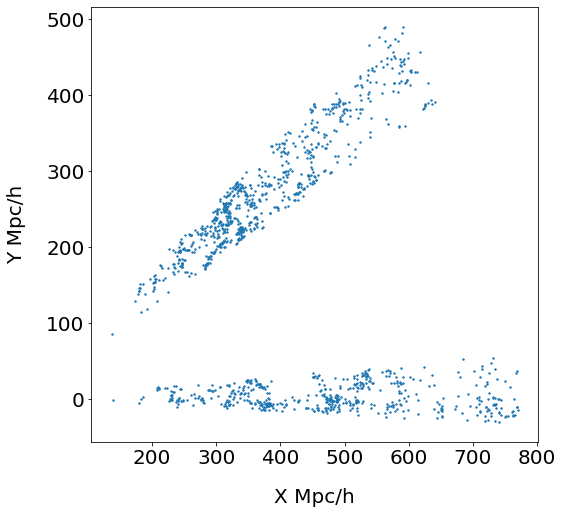

In [49]:
#- Final map for ddp1 and match_des filters
fig = pl.figure(figsize=(8,8))
pl.scatter( data_match['ROTCARTESIAN_X'][ii_ddp1 & ii_distance], data_match['ROTCARTESIAN_Y'][ii_ddp1 & ii_distance], s=2 )
pl.xlabel('X Mpc/h')
pl.ylabel('Y Mpc/h')
pl.show()

### G15

In [50]:
#- Field G15 GAMA
ii_g15 = data_match['FIELD'] == 'G15'
ii_g12 = data_match['FIELD'] == 'G12'
ii_g09 = data_match['FIELD'] == 'G9'
sum(ii_g09 & ii_ddp1), sum(ii_g12 & ii_ddp1), sum(ii_g15 & ii_ddp1)

(16562, 17992, 16318)

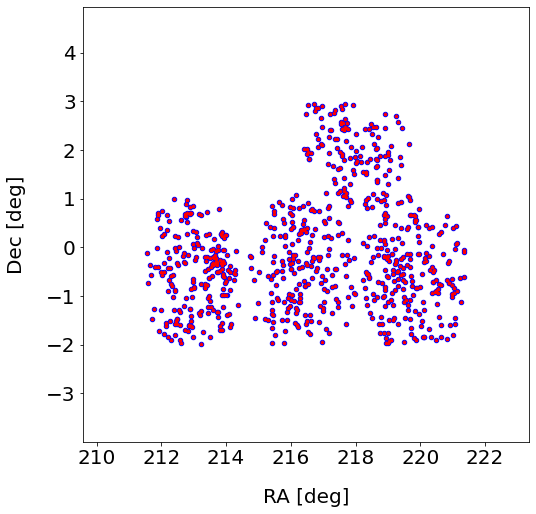

In [51]:
#- Apply the filters iiddp1 and ii_distance
fig = pl.figure(figsize=(8,8))
pl.scatter( data_match['RA'][ii_ddp1 & ii_distance & ii_g15], data_match['DEC'][ii_ddp1 & ii_distance & ii_g15], s=20, c='b', marker='o' )
pl.scatter( data_match['RA_DES'][ii_ddp1 & ii_distance & ii_g15], data_match['DEC_DES'][ii_ddp1 & ii_distance & ii_g15], s=10, c='r', marker='*' )
pl.xlim(min(ra_gama[ii_ddp1 & ii_distance & ii_g15])-2, max(ra_gama[ii_ddp1 & ii_distance & ii_g15])+2)
pl.ylim(min(dec_gama[ii_ddp1 & ii_distance & ii_g15])-2, max(dec_gama[ii_ddp1 & ii_distance & ii_g15])+2)
pl.xlabel('RA [deg]')
pl.ylabel('Dec [deg]')
pl.show()

In [52]:
#- Number of points in G15 for DDP1 matched with DES
len(data_match['RA'][ii_ddp1 & ii_distance & ii_g15])

766

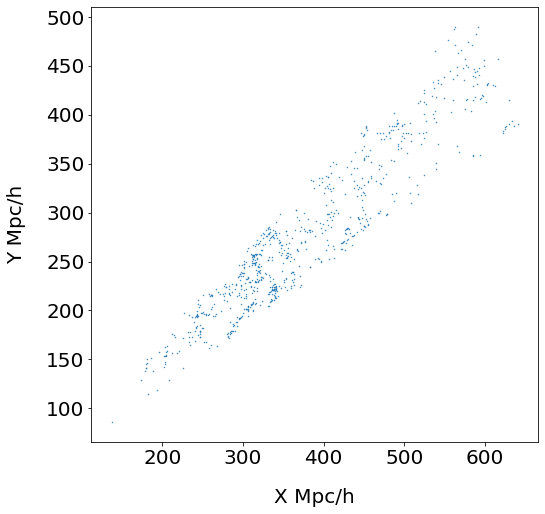

In [53]:
#- Final map for ddp1 and g15
fig = pl.figure(figsize=(8,8))
pl.scatter( data_match['ROTCARTESIAN_X'][ii_ddp1 & ii_g15 & ii_distance], data_match['ROTCARTESIAN_Y'][ii_ddp1 & ii_g15 & ii_distance], s=0.2 )
pl.xlabel('X Mpc/h')
pl.ylabel('Y Mpc/h')
pl.show()

In [44]:
# #- Final map for ddp1 and g15, color is the inclination 
# angcolor = data_match['PHI_DES'][ii_ddp1 & ii_g15]

# fig = pl.figure(figsize=(10,8))
# pl.scatter( data_match['ROTCARTESIAN_X'][ii_ddp1 & ii_g15], data_match['ROTCARTESIAN_Y'][ii_ddp1 & ii_g15], s=0.2, c=angcolor)
# pl.colorbar()
# pl.xlabel('X Mpc/h')
# pl.ylabel('Y Mpc/h')
# pl.show()

In [54]:
#- DataFrame with final pos ddp1 g15
xyz_labels = ['ROTCARTESIAN_X','ROTCARTESIAN_Y','ROTCARTESIAN_Z']
df_pos = data[xyz_labels].to_pandas()
df_pos

ROTCARTESIAN_X  ROTCARTESIAN_Y  ROTCARTESIAN_Z
0           360.247776     -326.165420       11.395235
1           117.562961      -10.185777        0.080162
2           553.820302      392.914451        0.936551
3           121.811730       91.147549        1.527326
4           463.335039     -490.195602       -6.128962
...                ...             ...             ...
121970      395.109849      333.191916        3.537985
121971      384.662170      279.166617        1.037473
121972      347.559951     -324.174592       20.962574
121973      285.037997      178.061442        8.120886
121974      454.926540      -41.971906        8.220755

[121975 rows x 3 columns]

In [55]:
#- Posicions git ddp1 + g15 to compute filaments
np.savetxt('./data/GAMADES_pos_ddp1_g15.txt', np.c_[np.arange(len(df_pos[ii_ddp1 & ii_g15].values)), df_pos[ii_ddp1 & ii_g15].values] , fmt='%d', header='id px py pz')
np.savetxt('./data/GAMADES_pos_ddp1_g12.txt', np.c_[np.arange(len(df_pos[ii_ddp1 & ii_g12].values)), df_pos[ii_ddp1 & ii_g12].values] , fmt='%d', header='id px py pz')
np.savetxt('./data/GAMADES_pos_ddp1_g09.txt', np.c_[np.arange(len(df_pos[ii_ddp1 & ii_g09].values)), df_pos[ii_ddp1 & ii_g09].values] , fmt='%d', header='id px py pz')

In [56]:
f_g15 = open('./data/GAMADES_pos_ddp1_g15.txt.NDnet_s2.up.NDskl.S001.a.NDskl')
doc_g15 = f_g15.readlines()

f_g12 = open('./data/GAMADES_pos_ddp1_g12.txt.NDnet_s2.up.NDskl.S001.a.NDskl')
doc_g12 = f_g12.readlines()

f_g09 = open('./data/GAMADES_pos_ddp1_g09.txt.NDnet_s2.up.NDskl.S001.a.NDskl')
doc_g09 = f_g09.readlines()

In [57]:
# Number of filaments from Disperse
doc_g15 = np.array(doc_g15)
iig15 = np.where(doc_g15=='[FILAMENTS]\n')[0][0]
N_fila_g15 = int(doc_g15[iig15+1])
print(N_fila_g15)

# Number of filaments from Disperse
doc_g12 = np.array(doc_g12)
iig12 = np.where(doc_g12=='[FILAMENTS]\n')[0][0]
N_fila_g12 = int(doc_g12[iig12+1])
print(N_fila_g12)

# Number of filaments from Disperse
doc_g09 = np.array(doc_g09)
iig09 = np.where(doc_g09=='[FILAMENTS]\n')[0][0]
N_fila_g09 = int(doc_g09[iig09+1])
print(N_fila_g09)

1888
1991
1946


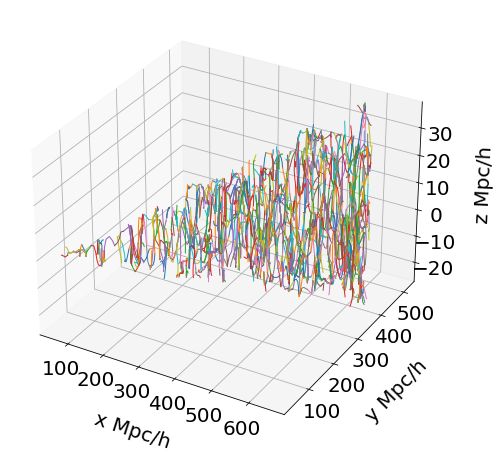

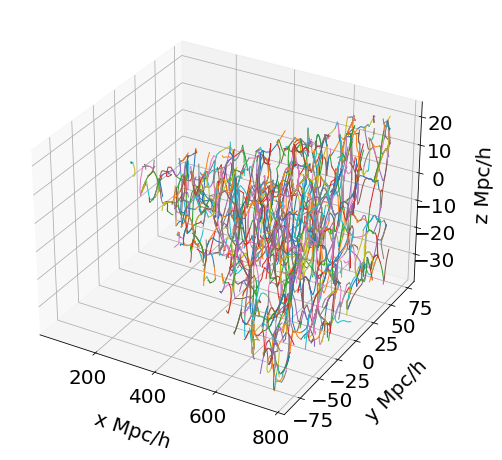

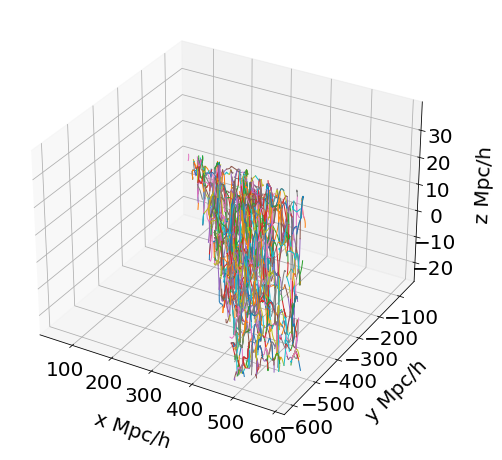

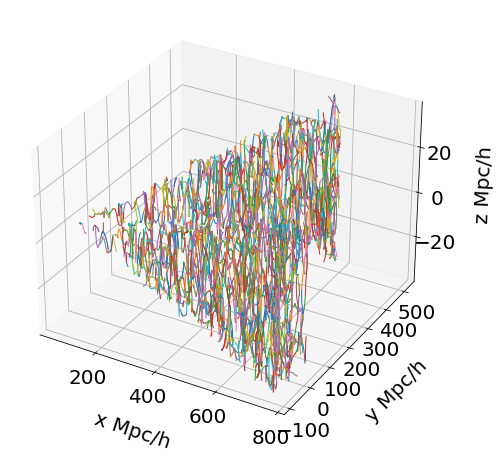

In [58]:
#- Plotting all the filaments
FILA_g15 = np.zeros(N_fila_g15, dtype=object)
jjg15 = iig15+2
jjnewg15 = 0
# print(doc[jj][0].replace('\n','').split(' ')[2])
fig = pl.figure(figsize=(8,8), rasterized=True)
ax = pl.axes(projection='3d')
ax.set_xlabel('x Mpc/h')
ax.set_ylabel('y Mpc/h')
ax.set_zlabel('z Mpc/h')
for i in range(N_fila_g15):
    jjnewg15 = jjg15 + int(doc_g15[jjg15].replace('\n','').split(' ')[2]) + 1
    FILA_g15[i] = np.array([a.replace('\n','').split(' ')[1:] for a in doc_g15[jjg15+1:jjnewg15]], dtype=float)
    # print(jj,jj_new)
    # print(doc[jj].replace('\n',''),doc[jj_new])
    ax.plot3D(FILA_g15[i][:,0], FILA_g15[i][:,1], FILA_g15[i][:,2], lw=1) 
    jjg15 = jjnewg15
pl.savefig('./figs/GAMADES_nsig2_smooth_smooth10_ddp1_g15_3D.pdf', bbox_inches='tight')    
pl.show()


FILA_g12 = np.zeros(N_fila_g12, dtype=object)
jjg12 = iig12+2
jjnewg12 = 0
fig = pl.figure(figsize=(8,8), rasterized=True)
ax = pl.axes(projection='3d')
ax.set_xlabel('x Mpc/h')
ax.set_ylabel('y Mpc/h')
ax.set_zlabel('z Mpc/h')
for i in range(N_fila_g12):
    jjnewg12 = jjg12 + int(doc_g12[jjg12].replace('\n','').split(' ')[2]) + 1
    FILA_g12[i] = np.array([a.replace('\n','').split(' ')[1:] for a in doc_g12[jjg12+1:jjnewg12]], dtype=float)
    # print(jj,jj_new)
    # print(doc[jj].replace('\n',''),doc[jj_new])
    ax.plot3D(FILA_g12[i][:,0], FILA_g12[i][:,1], FILA_g12[i][:,2], lw=1) 
    jjg12 = jjnewg12    
pl.savefig('./figs/GAMADES_nsig2_smooth_smooth10_ddp1_g12_3D.pdf', bbox_inches='tight')
pl.show()

FILA_g09 = np.zeros(N_fila_g09, dtype=object)
jjg09 = iig09+2
jjnewg09 = 0
fig = pl.figure(figsize=(8,8), rasterized=True)
ax = pl.axes(projection='3d')
ax.set_xlabel('x Mpc/h')
ax.set_ylabel('y Mpc/h')
ax.set_zlabel('z Mpc/h')
for i in range(N_fila_g09):
    jjnewg09 = jjg09 + int(doc_g09[jjg09].replace('\n','').split(' ')[2]) + 1
    FILA_g09[i] = np.array([a.replace('\n','').split(' ')[1:] for a in doc_g09[jjg09+1:jjnewg09]], dtype=float)
    # print(jj,jj_new)
    # print(doc[jj].replace('\n',''),doc[jj_new])
    ax.plot3D(FILA_g09[i][:,0], FILA_g09[i][:,1], FILA_g09[i][:,2], lw=1) 
    jjg09 = jjnewg09    
pl.savefig('./figs/GAMADES_nsig2_smooth_smooth10_ddp1_g09_3D.pdf', bbox_inches='tight')
pl.show()


FILA_g15 = np.zeros(N_fila_g15, dtype=object)
jjg15 = iig15+2
jjnewg15 = 0
FILA_g12 = np.zeros(N_fila_g12, dtype=object)
jjg12 = iig12+2
jjnewg12 = 0
fig = pl.figure(figsize=(8,8), rasterized=True)
ax = pl.axes(projection='3d')
ax.set_xlabel('x Mpc/h')
ax.set_ylabel('y Mpc/h')
ax.set_zlabel('z Mpc/h')
for i in range(N_fila_g15):
    jjnewg15 = jjg15 + int(doc_g15[jjg15].replace('\n','').split(' ')[2]) + 1
    FILA_g15[i] = np.array([a.replace('\n','').split(' ')[1:] for a in doc_g15[jjg15+1:jjnewg15]], dtype=float)
    # print(jj,jj_new)
    # print(doc[jj].replace('\n',''),doc[jj_new])
    ax.plot3D(FILA_g15[i][:,0], FILA_g15[i][:,1], FILA_g15[i][:,2], lw=1) 
    jjg15 = jjnewg15
for i in range(N_fila_g12):
    jjnewg12 = jjg12 + int(doc_g12[jjg12].replace('\n','').split(' ')[2]) + 1
    FILA_g12[i] = np.array([a.replace('\n','').split(' ')[1:] for a in doc_g12[jjg12+1:jjnewg12]], dtype=float)
    # print(jj,jj_new)
    # print(doc[jj].replace('\n',''),doc[jj_new])
    ax.plot3D(FILA_g12[i][:,0], FILA_g12[i][:,1], FILA_g12[i][:,2], lw=1) 
    jjg12 = jjnewg12    
pl.savefig('./figs/GAMADES_nsig2_smooth_smooth10_ddp1_g12_g15_3D.pdf', bbox_inches='tight')
pl.show()

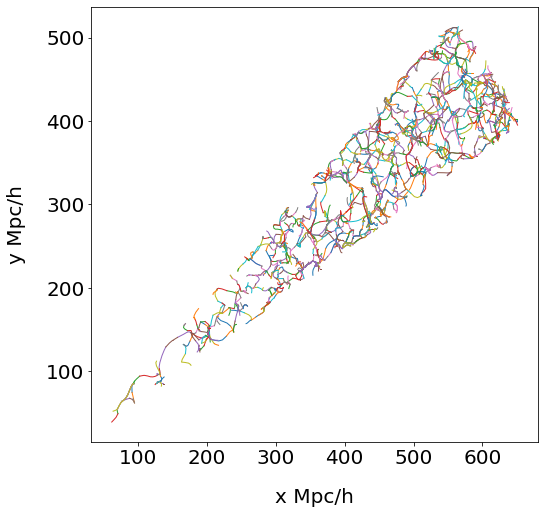

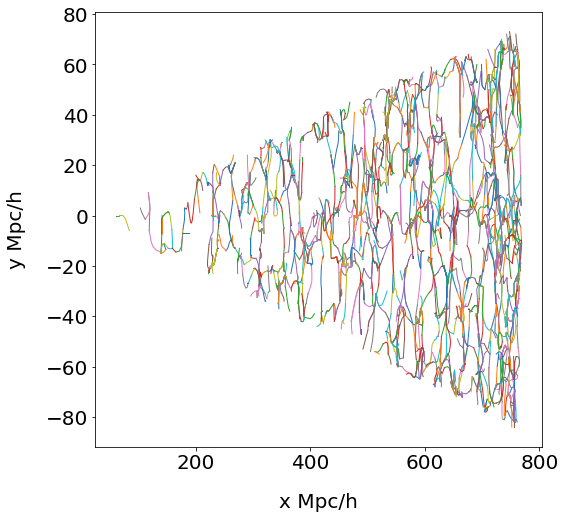

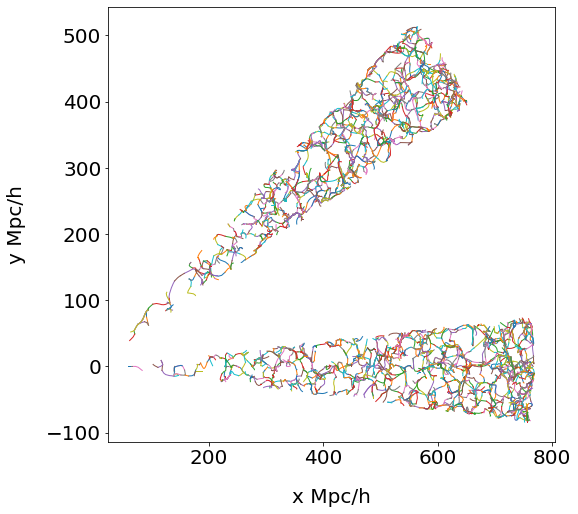

In [59]:
#- Plotting all the filaments in 2D
fig = pl.figure(figsize=(8,8), rasterized=True)
# pl.scatter( data_match['ROTCARTESIAN_X'][ii_ddp1 & ii_distance & ii_g15], data_match['ROTCARTESIAN_Y'][ii_ddp1 & ii_distance & ii_g15], s=0.1, alpha=0.5 )
jjg15 = iig15+2
jjnewg15 = 0
fila_x_g15 = []
fila_y_g15 = []
fila_z_g15 = []
for i in range(N_fila_g15):
    jjnewg15 = jjg15 + int(doc_g15[jjg15].replace('\n','').split(' ')[2]) + 1
    FILA_g15[i] = np.array([a.replace('\n','').split(' ')[1:] for a in doc_g15[jjg15+1:jjnewg15]], dtype=float)
    fila_x_g15.append( FILA_g15[i][:,0] ) 
    fila_y_g15.append( FILA_g15[i][:,1] ) 
    fila_z_g15.append( FILA_g15[i][:,2] ) 
    # print(jj,jj_new)
    # print(doc[jj].replace('\n',''),doc[jj_new])
    pl.plot(FILA_g15[i][:,0], FILA_g15[i][:,1], lw=1) 
    jjg15 = jjnewg15
pl.xlabel('x Mpc/h')
pl.ylabel('y Mpc/h')
pl.savefig('./figs/GAMADES_nsig2_smooth_smooth10_ddp1_g15_2D.pdf', bbox_inches='tight')
pl.show()

#- Plotting all the filaments in 2D
fig = pl.figure(figsize=(8,8), rasterized=True)
# pl.scatter( data_match['ROTCARTESIAN_X'][ii_ddp1 & ii_distance & ii_g15], data_match['ROTCARTESIAN_Y'][ii_ddp1 & ii_distance & ii_g15], s=0.1, alpha=0.5 )
jjg12 = iig12+2
jjnewg12 = 0
fila_x_g12 = []
fila_y_g12 = []
fila_z_g12 = []
for i in range(N_fila_g12):
    jjnewg12 = jjg12 + int(doc_g12[jjg12].replace('\n','').split(' ')[2]) + 1
    FILA_g12[i] = np.array([a.replace('\n','').split(' ')[1:] for a in doc_g12[jjg12+1:jjnewg12]], dtype=float)
    fila_x_g12.append( FILA_g12[i][:,0] ) 
    fila_y_g12.append( FILA_g12[i][:,1] ) 
    fila_z_g12.append( FILA_g12[i][:,2] ) 
    # print(jj,jj_new)
    # print(doc[jj].replace('\n',''),doc[jj_new])
    pl.plot(FILA_g12[i][:,0], FILA_g12[i][:,1], lw=1) 
    jjg12 = jjnewg12
pl.xlabel('x Mpc/h')
pl.ylabel('y Mpc/h')
pl.savefig('./figs/GAMADES_nsig2_smooth_smooth10_ddp1_g12_2D.pdf', bbox_inches='tight')
pl.show()


#- Plotting all the filaments in 2D
fig = pl.figure(figsize=(8,8), rasterized=True)
# pl.scatter( data_match['ROTCARTESIAN_X'][ii_ddp1 & ii_distance & ii_g15], data_match['ROTCARTESIAN_Y'][ii_ddp1 & ii_distance & ii_g15], s=0.1, alpha=0.5 )
jjg15 = iig15+2
jjnewg15 = 0
fila_x_g15 = []
fila_y_g15 = []
fila_z_g15 = []
for i in range(N_fila_g15):
    jjnewg15 = jjg15 + int(doc_g15[jjg15].replace('\n','').split(' ')[2]) + 1
    FILA_g15[i] = np.array([a.replace('\n','').split(' ')[1:] for a in doc_g15[jjg15+1:jjnewg15]], dtype=float)
    fila_x_g15.append( FILA_g15[i][:,0] ) 
    fila_y_g15.append( FILA_g15[i][:,1] ) 
    fila_z_g15.append( FILA_g15[i][:,2] ) 
    # print(jj,jj_new)
    # print(doc[jj].replace('\n',''),doc[jj_new])
    pl.plot(FILA_g15[i][:,0], FILA_g15[i][:,1], lw=1) 
    jjg15 = jjnewg15
jjg12 = iig12+2
jjnewg12 = 0
fila_x_g12 = []
fila_y_g12 = []
fila_z_g12 = []
for i in range(N_fila_g12):
    jjnewg12 = jjg12 + int(doc_g12[jjg12].replace('\n','').split(' ')[2]) + 1
    FILA_g12[i] = np.array([a.replace('\n','').split(' ')[1:] for a in doc_g12[jjg12+1:jjnewg12]], dtype=float)
    fila_x_g12.append( FILA_g12[i][:,0] ) 
    fila_y_g12.append( FILA_g12[i][:,1] ) 
    fila_z_g12.append( FILA_g12[i][:,2] ) 
    # print(jj,jj_new)
    # print(doc[jj].replace('\n',''),doc[jj_new])
    pl.plot(FILA_g12[i][:,0], FILA_g12[i][:,1], lw=1) 
    jjg12 = jjnewg12
pl.xlabel('x Mpc/h')
pl.ylabel('y Mpc/h')
pl.savefig('./figs/GAMADES_nsig2_smooth_smooth10_ddp1_g12_g15_2D.pdf', bbox_inches='tight')
pl.show()

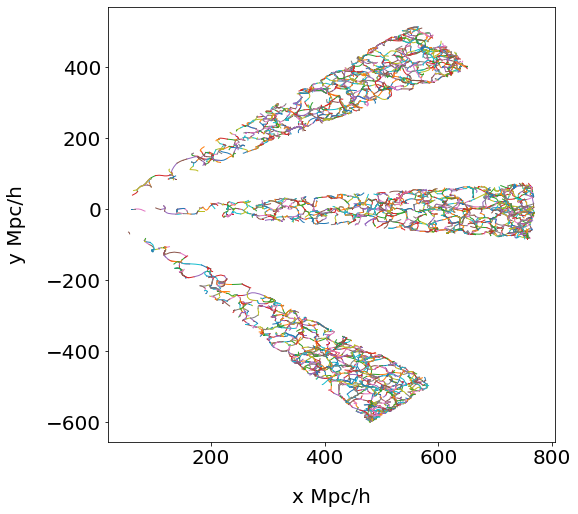

In [60]:
fig = pl.figure(figsize=(8,8), rasterized=True)
# pl.scatter( data_match['ROTCARTESIAN_X'][ii_ddp1 & ii_distance & ii_g15], data_match['ROTCARTESIAN_Y'][ii_ddp1 & ii_distance & ii_g15], s=0.1, alpha=0.5 )
jjg15 = iig15+2
jjnewg15 = 0
fila_x_g15 = []
fila_y_g15 = []
fila_z_g15 = []
for i in range(N_fila_g15):
    jjnewg15 = jjg15 + int(doc_g15[jjg15].replace('\n','').split(' ')[2]) + 1
    FILA_g15[i] = np.array([a.replace('\n','').split(' ')[1:] for a in doc_g15[jjg15+1:jjnewg15]], dtype=float)
    fila_x_g15.append( FILA_g15[i][:,0] ) 
    fila_y_g15.append( FILA_g15[i][:,1] ) 
    fila_z_g15.append( FILA_g15[i][:,2] ) 
    # print(jj,jj_new)
    # print(doc[jj].replace('\n',''),doc[jj_new])
    pl.plot(FILA_g15[i][:,0], FILA_g15[i][:,1], lw=1) 
    jjg15 = jjnewg15
jjg12 = iig12+2
jjnewg12 = 0
fila_x_g12 = []
fila_y_g12 = []
fila_z_g12 = []
for i in range(N_fila_g12):
    jjnewg12 = jjg12 + int(doc_g12[jjg12].replace('\n','').split(' ')[2]) + 1
    FILA_g12[i] = np.array([a.replace('\n','').split(' ')[1:] for a in doc_g12[jjg12+1:jjnewg12]], dtype=float)
    fila_x_g12.append( FILA_g12[i][:,0] ) 
    fila_y_g12.append( FILA_g12[i][:,1] ) 
    fila_z_g12.append( FILA_g12[i][:,2] ) 
    # print(jj,jj_new)
    # print(doc[jj].replace('\n',''),doc[jj_new])
    pl.plot(FILA_g12[i][:,0], FILA_g12[i][:,1], lw=1) 
    jjg12 = jjnewg12
jjg09 = iig09+2
jjnewg09 = 0
fila_x_g09 = []
fila_y_g09 = []
fila_z_g09 = []
for i in range(N_fila_g09):
    jjnewg09 = jjg09 + int(doc_g09[jjg09].replace('\n','').split(' ')[2]) + 1
    FILA_g09[i] = np.array([a.replace('\n','').split(' ')[1:] for a in doc_g09[jjg09+1:jjnewg09]], dtype=float)
    fila_x_g09.append( FILA_g09[i][:,0] ) 
    fila_y_g09.append( FILA_g09[i][:,1] ) 
    fila_z_g09.append( FILA_g09[i][:,2] ) 
    # print(jj,jj_new)
    # print(doc[jj].replace('\n',''),doc[jj_new])
    pl.plot(FILA_g09[i][:,0], FILA_g09[i][:,1], lw=1) 
    jjg09 = jjnewg09
    
pl.xlabel('x Mpc/h')
pl.ylabel('y Mpc/h')
pl.savefig('./figs/GAMADES_nsig2_smooth_smooth10_ddp1_g09_g12_g15_2D.pdf', bbox_inches='tight')
pl.show()

In [61]:
sum(ii_ddp1 & ii_distance & ii_g15), sum(ii_ddp1 & ii_g15)

(766, 16318)

In [62]:
#Lenght of each filament
LEN_FILA = np.array([len(i) for i in FILA_g15])
LEN_FILA

array([ 9,  4, 13, ...,  2,  5,  3])

## Finding the nearest Filament

In [85]:
def get_ID_FILA(pos,L):
    total = 0
    for i, l in enumerate(L):
        total += l
        if pos < total:
            return i

def get_distance(x1,y1,z1,x2,y2,z2):
    return np.sqrt( (x1-x2)**2 +(y1-y2)**2 +(z1-z2)**2   )

In [86]:
#- Extend all the filaments
fila_x_arr = np.concatenate(fila_x_g15).ravel()
fila_y_arr = np.concatenate(fila_y_g15).ravel()
fila_z_arr = np.concatenate(fila_z_g15).ravel()
len(fila_x_arr)

13052

In [87]:
#- Setting the ID for the filaments
id_fila_arr = np.zeros(len(fila_x_arr))
for i in  np.arange(len(fila_x_arr)):
    id_fila_arr[i] = get_ID_FILA(i, LEN_FILA)

In [88]:
#- Save the filaments(segments) and their ids
df_fila = pd.DataFrame()
df_fila['id_fila'] = id_fila_arr
df_fila['x_fila'] = fila_x_arr
df_fila['y_fila'] = fila_y_arr
df_fila['z_fila'] = fila_z_arr
df_fila.to_csv('./data/filaments_ddp1_g15.csv')

In [89]:
#- DataFrame with positions matched with DESI
xyz_labels = ['ROTCARTESIAN_X','ROTCARTESIAN_Y','ROTCARTESIAN_Z']
df_pos_des = data[xyz_labels].to_pandas()
df_pos_des = df_pos_des[ii_ddp1 & ii_g15 & ii_distance]
# df_pos_des

In [90]:
#- Find the nearest filament point to each galaxy
tree_fila = KDTree(np.c_[fila_x_arr, fila_y_arr, fila_z_arr])
distances_fila, indices_fila = tree_fila.query(np.c_[df_pos_des], k=1)

In [91]:
#- Identifying the nearest segment using distance and Filament ID
ID_FILA = np.zeros(len(indices_fila), dtype=int)
ID_FILA_NEXT = np.zeros(len(indices_fila), dtype=int)
ID_FILA_LAST = np.zeros(len(indices_fila), dtype=int)
ID_FILA_SEGMENTS = np.zeros(len(indices_fila), dtype=object)

for i, index in enumerate(indices_fila):
    ID_FILA[i]      = get_ID_FILA(index, LEN_FILA)
    ID_FILA_NEXT[i] = get_ID_FILA(index+1, LEN_FILA)
    ID_FILA_LAST[i] = get_ID_FILA(index-1, LEN_FILA)

    if (get_ID_FILA(index, LEN_FILA) == get_ID_FILA(index+1, LEN_FILA)) & (get_ID_FILA(index, LEN_FILA) != get_ID_FILA(index-1, LEN_FILA)):
        ID_FILA_SEGMENTS[i] = np.array([index,index+1])

    elif (get_ID_FILA(index, LEN_FILA) != get_ID_FILA(index+1, LEN_FILA)) & (get_ID_FILA(index, LEN_FILA) == get_ID_FILA(index-1, LEN_FILA)):
        ID_FILA_SEGMENTS[i] = np.array([index,index-1])

    elif (get_ID_FILA(index, LEN_FILA) == get_ID_FILA(index+1, LEN_FILA)) & (get_ID_FILA(index, LEN_FILA) == get_ID_FILA(index-1, LEN_FILA)):
        d_next = get_distance(fila_x_arr[index],fila_y_arr[index],fila_z_arr[index],fila_x_arr[index+1],fila_y_arr[index+1],fila_z_arr[index+1])
        d_last = get_distance(fila_x_arr[index],fila_y_arr[index],fila_z_arr[index],fila_x_arr[index-1],fila_y_arr[index-1],fila_z_arr[index-1])
        if d_next < d_last:
            ID_FILA_SEGMENTS[i] = np.array([index, index+1])
        elif d_next >= d_last:
            ID_FILA_SEGMENTS[i] = np.array([index, index-1])

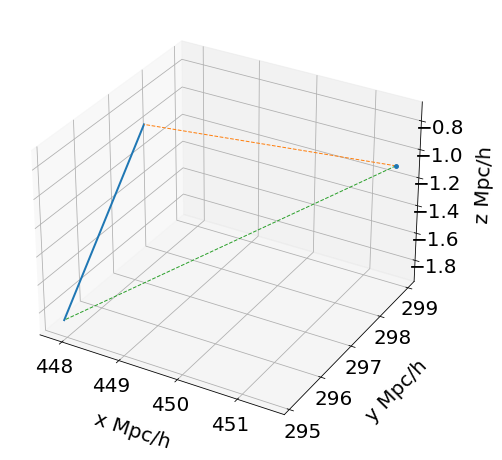

In [92]:
#- Plot the galaxy and its segment filament
fig = pl.figure(figsize=(8,8), rasterized=True)
ax = pl.axes(projection='3d')
ax.set_xlabel('x Mpc/h')
ax.set_ylabel('y Mpc/h')
ax.set_zlabel('z Mpc/h')
for N in [0]:
    ax.scatter3D(np.array(df_pos_des['ROTCARTESIAN_X'])[N],
                 np.array(df_pos_des['ROTCARTESIAN_Y'])[N],
                 np.array(df_pos_des['ROTCARTESIAN_Z'])[N], s=15)
    
    ax.plot3D(fila_x_arr[ID_FILA_SEGMENTS[N]],
              fila_y_arr[ID_FILA_SEGMENTS[N]],
              fila_z_arr[ID_FILA_SEGMENTS[N]], lw=2)
    
    ax.plot3D([np.array(df_pos_des['ROTCARTESIAN_X'])[N], fila_x_arr[ID_FILA_SEGMENTS[N]][0]],
              [np.array(df_pos_des['ROTCARTESIAN_Y'])[N], fila_y_arr[ID_FILA_SEGMENTS[N]][0]],
              [np.array(df_pos_des['ROTCARTESIAN_Z'])[N], fila_z_arr[ID_FILA_SEGMENTS[N]][0]], '--', lw=1)
    
    ax.plot3D([np.array(df_pos_des['ROTCARTESIAN_X'])[N], fila_x_arr[ID_FILA_SEGMENTS[N]][1]],
              [np.array(df_pos_des['ROTCARTESIAN_Y'])[N], fila_y_arr[ID_FILA_SEGMENTS[N]][1]],
              [np.array(df_pos_des['ROTCARTESIAN_Z'])[N], fila_z_arr[ID_FILA_SEGMENTS[N]][1]], '--', lw=1)


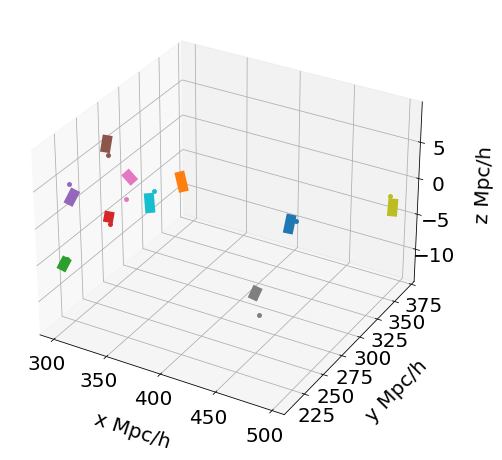

In [93]:
#- Plot galaxies and their nearest filaments - 10 examples
fig = pl.figure(figsize=(8,8), rasterized=True)
ax = pl.axes(projection='3d')
ax.set_xlabel('x Mpc/h')
ax.set_ylabel('y Mpc/h')
ax.set_zlabel('z Mpc/h')
for N in np.arange(10):
    ax.scatter3D(np.array(df_pos_des['ROTCARTESIAN_X'])[N],
                 np.array(df_pos_des['ROTCARTESIAN_Y'])[N],
                 np.array(df_pos_des['ROTCARTESIAN_Z'])[N], s=15)
    
    ax.plot3D(fila_x_arr[ID_FILA_SEGMENTS[N]],
              fila_y_arr[ID_FILA_SEGMENTS[N]],
              fila_z_arr[ID_FILA_SEGMENTS[N]], lw=10)
    
#     ax.plot3D([np.array(df_pos['ROTCARTESIAN_X'])[N], fila_x_arr[ID_FILA_SEGMENTS[N]][0]],
#               [np.array(df_pos['ROTCARTESIAN_Y'])[N], fila_y_arr[ID_FILA_SEGMENTS[N]][0]],
#               [np.array(df_pos['ROTCARTESIAN_Z'])[N], fila_z_arr[ID_FILA_SEGMENTS[N]][0]], '--', lw=1)
    
#     ax.plot3D([np.array(df_pos['ROTCARTESIAN_X'])[N], fila_x_arr[ID_FILA_SEGMENTS[N]][1]],
#               [np.array(df_pos['ROTCARTESIAN_Y'])[N], fila_y_arr[ID_FILA_SEGMENTS[N]][1]],
#               [np.array(df_pos['ROTCARTESIAN_Z'])[N], fila_z_arr[ID_FILA_SEGMENTS[N]][1]], '--', lw=1)

In [94]:
# df_filaments = pd.DataFrame()
# df_filaments['FILAMENTS'] = FILA    #Save the filaments
# df_filaments['LEN_FILA'] = LEN_FILA # Save the number of point of each filament
# df_filaments['ID_FILA_SEGMENT'] = ID_FILA_SEGMENTS # Save the ids of the nearest filament segments by galaxy

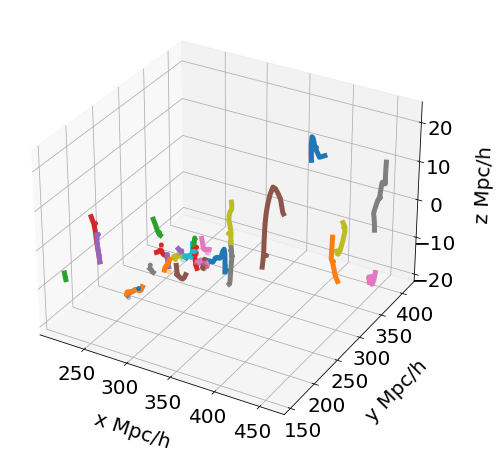

In [95]:
#- Plot Filaments that have more than 0 galxies near and within a min_dis_fil in 3D
Ns = np.arange(100)
fig = pl.figure(figsize=(8,8))
ax = pl.axes(projection='3d')
ax.set_xlabel('x Mpc/h')
ax.set_ylabel('y Mpc/h')
ax.set_zlabel('z Mpc/h')

min_dis_fil = 3

for N in Ns:
    ii_fila = ID_FILA == N
    ii_fila_distance = distances_fila[ii_fila] < min_dis_fil
    if  sum(ii_fila_distance)>0:
        ax.scatter3D(data_match[ii_ddp1 & ii_g15 & ii_distance]['ROTCARTESIAN_X'][ii_fila][ii_fila_distance],
                     data_match[ii_ddp1 & ii_g15 & ii_distance]['ROTCARTESIAN_Y'][ii_fila][ii_fila_distance],
                     data_match[ii_ddp1 & ii_g15 & ii_distance]['ROTCARTESIAN_Z'][ii_fila][ii_fila_distance], s=15)
        ax.plot3D(FILA_g15[N][:,0], FILA_g15[N][:,1], FILA_g15[N][:,2], lw=5)

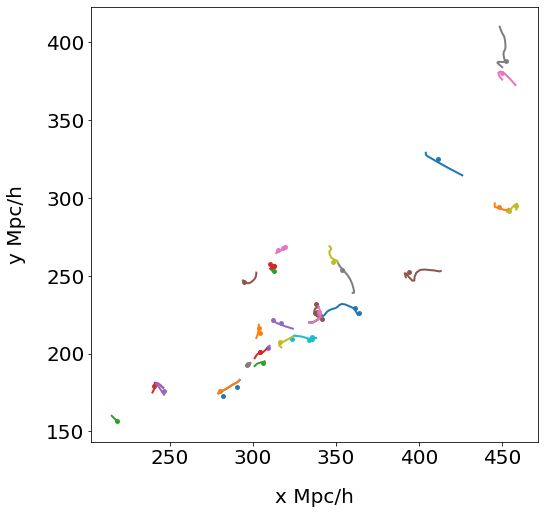

In [96]:
#- Same figure in 2D
Ns = np.arange(100)
fig = pl.figure(figsize=(8,8))

for N in Ns:
    ii_fila = ID_FILA == N
    ii_fila_distance = distances_fila[ii_fila] < min_dis_fil
    if sum(ii_fila_distance) != 0:
        pl.scatter(data_match[ii_ddp1 & ii_g15 & ii_distance]['ROTCARTESIAN_X'][ii_fila][ii_fila_distance],
                     data_match[ii_ddp1 & ii_g15 & ii_distance]['ROTCARTESIAN_Y'][ii_fila][ii_fila_distance], s=15)
        pl.plot(FILA_g15[N][:,0], FILA_g15[N][:,1], lw=2)
pl.xlabel('x Mpc/h')
pl.ylabel('y Mpc/h')
pl.show()

In [97]:
np.shape(distances_fila)

(766,)

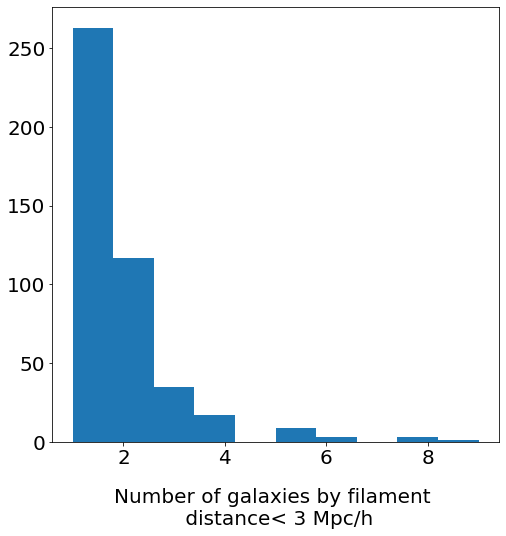

In [98]:
fig = pl.figure(figsize=(8,8))
_, counts = np.unique(ID_FILA, return_counts=True)
pl.hist(counts)
pl.xlabel(f'Number of galaxies by filament \n distance< {min_dis_fil} Mpc/h') # Number of points by filament with a minimal distance of min_dist to filament
pl.show()

## Computing the Tilt of the Segments

765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765
765


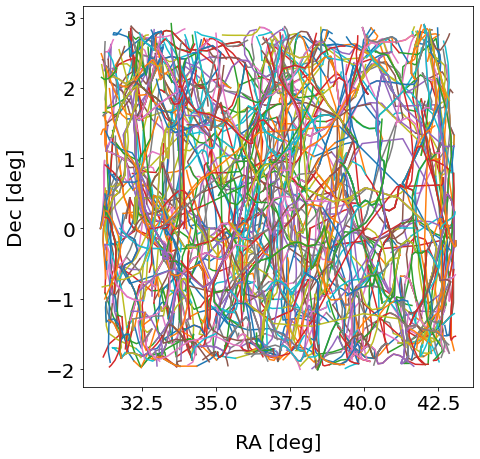

In [158]:
#- Projection of the filaments in the RADEC space
Ns = np.arange(1)
fig = pl.figure(figsize=(7,7))
tilt_fila_all_segments = []
ii_error = []
for fil in FILA_g15:
    # print(sum(ii_fila_distance))    
    c = SkyCoord(x=fil[:,0], y=fil[:,1], z=fil[:,2], unit='Mpc/h', representation_type='cartesian')
    c.representation_type = 'spherical'
    pl.plot(c.to_table()['ra'], c.to_table()['dec'])
    
    if c.to_table()['ra'][0].to_value()==c.to_table()['ra'][1].to_value():
        # print(i)
        ii_error.append(i)
    
    tilt_fila_all_segments.append( np.arctan2( (c.to_table()['dec'][0].to_value()-c.to_table()['dec'][1].to_value()),(c.to_table()['ra'][0].to_value()-c.to_table()['ra'][1].to_value()) )*180/np.pi)
    
pl.xlabel('RA [deg]')
pl.ylabel('Dec [deg]')
pl.show()

In [164]:
ii_error
ii_tilt_error = []
for i in range(len((tilt_fila_all_segments))):
    if i in ii_error:
        ii_tilt_error.append(False)
    else:
        ii_tilt_error.append(True)

Text(0.5, 0, 'All Filament Segements Orientation')

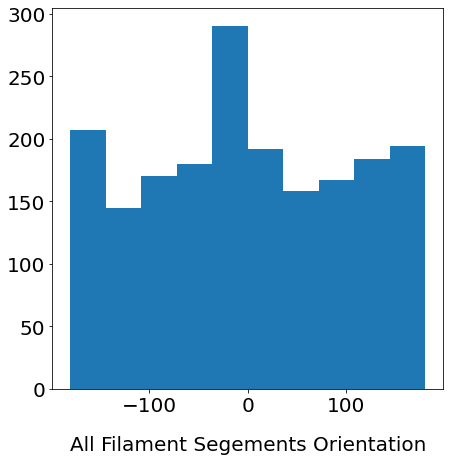

In [165]:
_ = pl.hist(np.array(tilt_fila_all_segments)[ii_tilt_error])
pl.xlabel('All Filament Segements Orientation')

In [101]:
# c = SkyCoord(x=fil[:,0]*-1, y=fil[:,1]*-1, z=fil[:,2], unit='Mpc/h', representation_type='cartesian')
# c.representation_type = 'unitspherical'
# c.to_table()

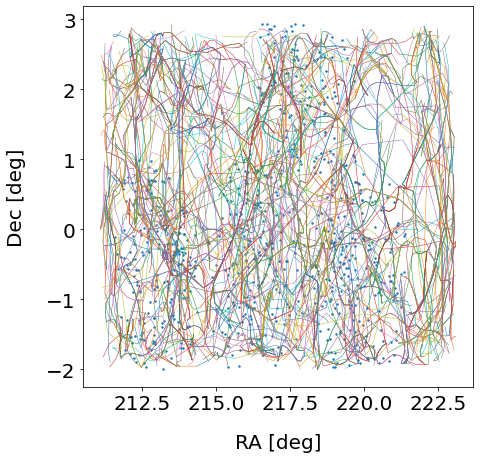

In [102]:
#- Filaments and galaxies projected in RADEC
fig = pl.figure(figsize=(7,7))

for fil in FILA_g15:
    # print(sum(ii_fila_distance))    
    c = SkyCoord(x=fil[:,0]*-1, y=fil[:,1]*-1, z=fil[:,2], unit='Mpc/h', representation_type='cartesian')
    c.representation_type = 'spherical'
    pl.plot(np.array(c.to_table()['ra']), np.array(c.to_table()['dec']), lw=0.5)
    
pl.scatter(data_match[ii_ddp1 & ii_g15 & ii_distance]['RA'],
           data_match[ii_ddp1 & ii_g15 & ii_distance]['DEC'], s=2)
pl.xlabel('RA [deg]')
pl.ylabel('Dec [deg]')
pl.show()

In [107]:
len(ID_FILA_SEGMENTS)

766

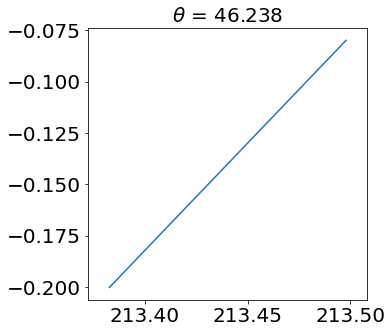

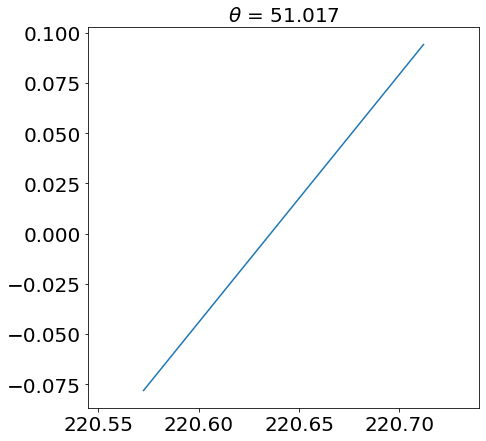

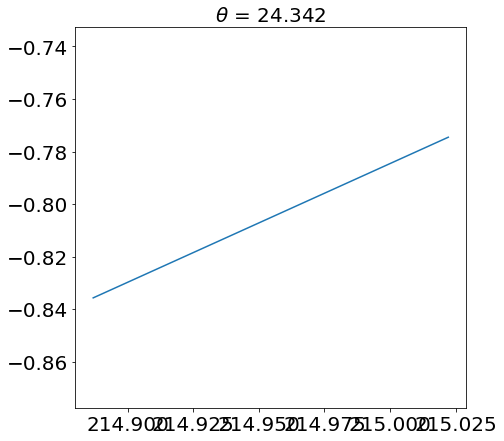

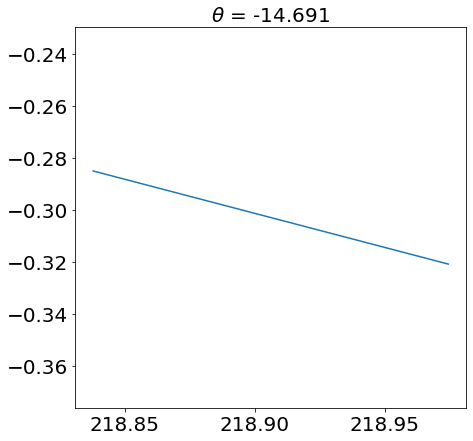

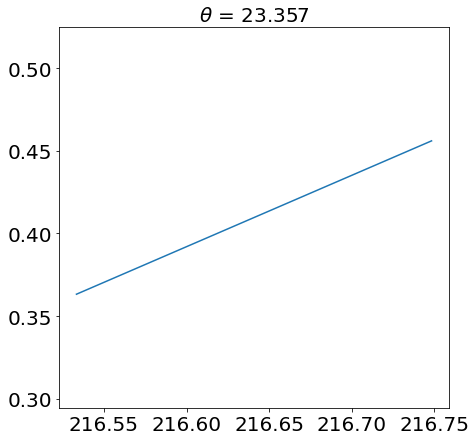

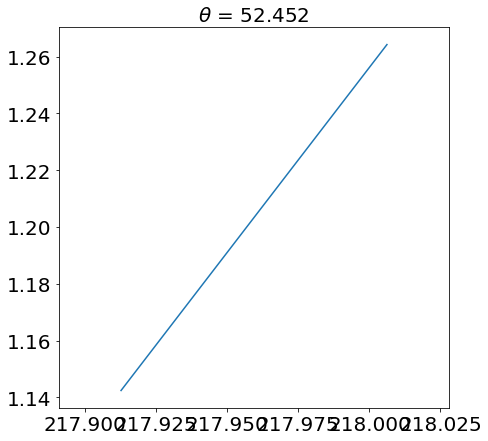

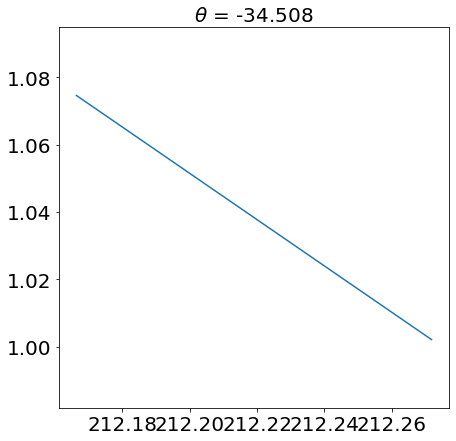

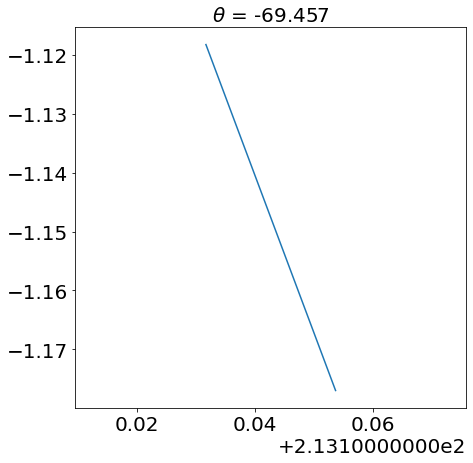

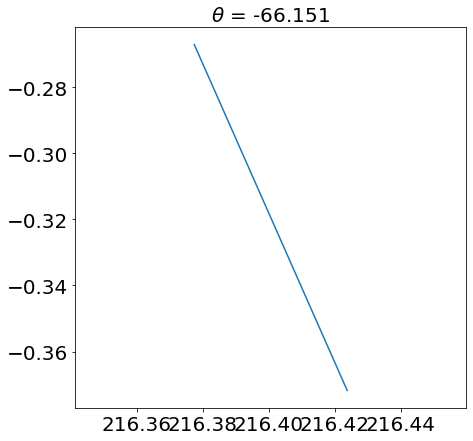

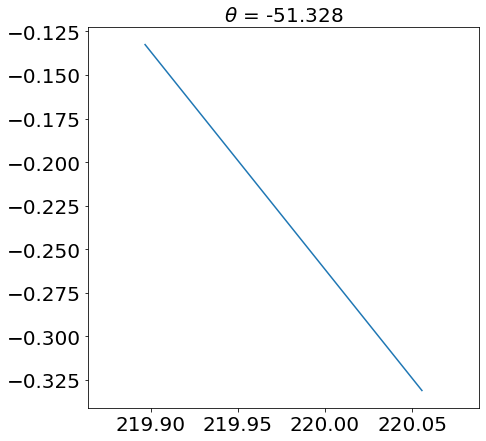

133


/tmp/ipykernel_43072/162258264.py:23: RuntimeWarning: invalid value encountered in double_scalars
  tilt_temp = np.arctan( (dec_[1]-dec_[0])/(ra_[1]-ra_[0]) )*180/np.pi


167


/tmp/ipykernel_43072/162258264.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  tilt_temp = np.arctan( (dec_[1]-dec_[0])/(ra_[1]-ra_[0]) )*180/np.pi


199
205
245
382
397
413
510
574
621
627
633


In [140]:
#- Filaments and galaxies projected in RADEC with a correction in RA +180.5
fig = pl.figure(figsize=(5,5))

c = SkyCoord(x=fila_x_arr*-1, y=fila_y_arr*-1, z=fila_z_arr, unit='Mpc/h', representation_type='cartesian')
c.representation_type = 'spherical'

ra_fila_segment   = []
dec_fila_segment  = []
tilt_fila_segment = []

ii_error = []

for i, ifs in enumerate(ID_FILA_SEGMENTS):
    ra_ = [c.to_table()[ 'ra'][ifs[0]].to_value(), c.to_table()[ 'ra'][ifs[1]].to_value()]
    dec_ = [c.to_table()['dec'][ifs[0]].to_value(), c.to_table()['dec'][ifs[1]].to_value()]
    ra_fila_segment.append(ra_)
    dec_fila_segment.append(dec_)
    
    if ra_[0] == ra_[1]:
        print(i)
        ii_error.append(i)
    
    tilt_temp = np.arctan( (dec_[1]-dec_[0])/(ra_[1]-ra_[0]) )*180/np.pi
    
    tilt_fila_segment.append(tilt_temp)
    
    if i < 10:
        # np.arctan( (dec_[1]-dec_[0])/(ra_[1]-ra_[0]) )*180/np.pi

        # tilt_fila_segment.append(tilt_temp)

    # if i < 10:
        pl.plot(ra_,dec_)
        pl.title(rf'$\theta$ = {tilt_temp:.3f}')
    #     # print( (dec_[1]-dec_[0])/(ra_[1]-ra_[0]))
        pl.axis('equal')
        pl.show()
    
# pl.scatter(data_match[ii_ddp1 & ii_g15 & ii_distance]['RA'],
#            data_match[ii_ddp1 & ii_g15 & ii_distance]['DEC'], s=5)
# pl.xlabel('RA [deg]')
# pl.ylabel('Dec [deg]')
# pl.show()

In [141]:
ii_error
ii_tilt_error = []
for i in range(len(tilt_fila_segment)):
    if i in ii_error:
        ii_tilt_error.append(False)
    else:
        ii_tilt_error.append(True)

In [132]:
# tilt_fila_segment = np.array(tilt_fila_segment) 
# # tilt_fila_segment[tilt_fila_segment>0.1 & tilt_fila_segment<0.2]
# tilt_fila_segment[(tilt_fila_segment > -2) & (tilt_fila_segment < 2)]

array([ 0.02412937,  0.80259345, -0.01677548,  0.02412937, -1.63741747,
        0.02493329,  0.43196178,  0.3572017 , -1.91634887,  0.17869816,
       -0.92593741, -1.65979046,  0.80259345,  1.64293717, -0.05224014,
        0.02493329, -1.86541945,  0.54788877,  0.49013968, -0.30241661,
        1.73324343,  0.35404496, -0.0474417 ,  0.02412937, -1.49851458,
        0.10722864,  0.35733341,  0.02412937])

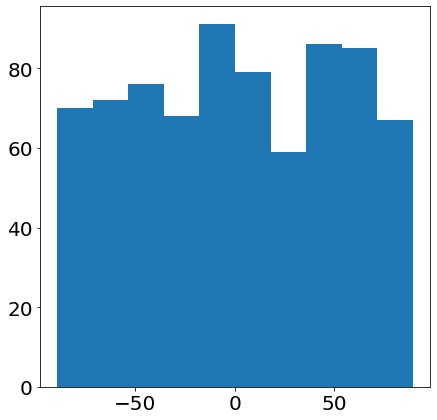

In [144]:
_ = pl.hist(np.array(tilt_fila_segment)[ii_tilt_error])

In [145]:
max(tilt_fila_segment)

90.0

In [146]:
#- DataFrame with PHI, RA, DEC galaxie and X,Y,Z,RAs,Decs and TILT segments
c = SkyCoord(x=fila_x_arr, y=fila_y_arr, z=fila_z_arr, unit='Mpc/h', representation_type='cartesian')
c.representation_type = 'spherical'

[c.to_table()[ 'ra'][ifs[0]].to_value(), c.to_table()[ 'ra'][ifs[1]].to_value()],
[c.to_table()['dec'][ifs[0]].to_value(), c.to_table()['dec'][ifs[1]].to_value()]

df_segments = pd.DataFrame()
x_fila_segment = [ fila_x_arr[ids] for ids in ID_FILA_SEGMENTS]
y_fila_segment = [ fila_y_arr[ids] for ids in ID_FILA_SEGMENTS]
z_fila_segment = [ fila_z_arr[ids] for ids in ID_FILA_SEGMENTS]

df_segments['PHI_DES'] = data_match['PHI_DES'][ii_ddp1 & ii_distance & ii_g15]
df_segments['RA_DES'] = data_match['RA_DES'][ii_ddp1 & ii_distance & ii_g15]
df_segments['DEC_DES'] = data_match['DEC_DES'][ii_ddp1 & ii_distance & ii_g15]
df_segments['Z_DES'] = data_match['Z_DES'][ii_ddp1 & ii_distance & ii_g15]
df_segments['Z_GAMA'] = data_match['ZGAMA'][ii_ddp1 & ii_distance & ii_g15]
df_segments['UMAG'] = data_match['UMAG_DRED_SDSS'][ii_ddp1 & ii_distance & ii_g15]
df_segments['ZMAG'] = data_match['ZMAG_DRED_SDSS'][ii_ddp1 & ii_distance & ii_g15]
df_segments['RMAG'] = data_match['RMAG_DRED_SDSS'][ii_ddp1 & ii_distance & ii_g15]
df_segments['GMAG'] = data_match['GMAG_DRED_SDSS'][ii_ddp1 & ii_distance & ii_g15]
df_segments['IMAG'] = data_match['IMAG_DRED_SDSS'][ii_ddp1 & ii_distance & ii_g15]
df_segments['X_NEAREST_SEGMENT']   = x_fila_segment
df_segments['Y_NEAREST_SEGMENT']   = y_fila_segment
df_segments['Z_NEAREST_SEGMENT']   = z_fila_segment
df_segments['RA_NEAREST_SEGMENT']  = ra_fila_segment
df_segments['DEC_NEAREST_SEGMENT'] = dec_fila_segment
df_segments['TILT_NEAREST_SEGMENT'] = tilt_fila_segment
df_segments['DISTANCE_NEAREST_SEGMENT'] = distances_fila

df_segments = df_segments[ii_tilt_error]
df_segments

PHI_DES      RA_DES   DEC_DES     Z_DES   Z_GAMA       UMAG       ZMAG  \
0    -9.821419  213.908702 -0.063244  0.187359  0.18753  20.972759  17.231169   
1    61.507767  221.137031  0.084724  0.157393  0.15736  21.571339  17.722908   
2    43.649391  215.394904 -0.651079  0.126911  0.12698  18.766466  16.669077   
3   -19.925270  219.365848 -0.395454  0.138399  0.13787  18.934591  16.753056   
4    87.674500  216.614534  0.773138  0.127943  0.12794  20.562536  16.883379   
..         ...         ...       ...       ...      ...        ...        ...   
761  34.638416  217.253296  0.195802  0.137689  0.13768  20.243780  16.612101   
762 -25.863861  216.649507 -0.637827  0.175464  0.17532  21.771660  17.901051   
763 -21.857796  215.107675 -0.103546  0.132050  0.13196  20.409729  16.685093   
764 -67.656090  213.234181  0.670872  0.217618  0.21766  21.987728  17.965689   
765  -9.012772  218.650026  1.788373  0.077459  0.07741  19.184801  15.843497   

          RMAG       GMAG       IMAG   X_NEAREST_SEGMENT   Y_NEAREST_SEGMENT  \
0    18.094534  19.323952  17.614418  [448.375, 447.875]   [296.75, 295.125]   
1    18.427305  19.477240  18.005814  [345.875, 347.875]  [297.625, 297.875]   
2    17.223135  17.773279  16.908648   [302.875, 302.25]    [212.25, 210.75]   
3    17.424578  18.163158  16.893360     [312.25, 313.0]    [252.625, 252.0]   
4    17.633198  18.646011  17.235529      [301.0, 302.0]      [223.0, 225.5]   
..         ...        ...        ...                 ...                 ...   
761  17.321835  18.347319  16.910233    [322.5, 319.875]    [237.0, 237.875]   
762  18.701424  19.792831  18.248770    [410.0, 410.625]    [300.125, 298.5]   
763  17.449217  18.482803  17.042162  [316.875, 314.625]      [218.5, 219.5]   
764  18.742537  19.966610  18.274460  [516.375, 517.875]   [339.625, 342.25]   
765  16.508690  17.344469  16.125853    [179.0, 177.625]     [141.0, 144.75]   

    Z_NEAREST_SEGMENT                        RA_NEAREST_SEGMENT  \
0     [-0.75, -1.875]  [213.49796169258374, 213.38268570995024]   
1      [0.75, -0.625]  [220.71195341896697, 220.57245932810676]   
2      [-5.0, -5.375]   [215.02216250973152, 214.8869255065758]   
3       [-2.25, -2.0]   [218.97449465359534, 218.8379523501161]   
4        [2.375, 3.0]  [216.53340734755182, 216.74828301391483]   
..                ...                                       ...   
761      [-1.0, -2.5]   [216.31156064710493, 216.6363319488305]   
762   [-7.875, -6.75]   [216.20458267203202, 216.0149265749995]   
763    [-1.5, -1.125]   [214.58806314028456, 214.9017834734421]   
764      [8.75, 16.0]  [213.33331937212063, 213.45966965446414]   
765       [7.0, 6.25]  [218.22784003388645, 219.17724776286863]   

                              DEC_NEAREST_SEGMENT  TILT_NEAREST_SEGMENT  \
0     [-0.0799206560347466, -0.20028995207462277]             46.238217   
1     [0.09417433228890962, -0.07819067935898019]             51.016937   
2      [-0.7745502470574437, -0.8357326912224989]             24.342426   
3     [-0.32096467497919884, -0.2851668805959552]            -14.690810   
4       [0.3632496169322045, 0.45604489637923507]             23.357376   
..                                            ...                   ...   
761   [-0.14316076926193047, -0.3593261354132794]            -33.647441   
762    [-0.8879352940766171, -0.7617822457868756]            -33.630555   
763  [-0.22328415783932695, -0.16802176132103563]              9.990264   
764      [0.8111042045288966, 1.4764892604039586]             79.248090   
765      [1.7595775160261105, 1.5624354326251226]            -11.730620   

     DISTANCE_NEAREST_SEGMENT  
0                    3.838599  
1                    1.089284  
2                    1.515506  
3                    1.054352  
4                    3.189807  
..                        ...  
761                  4.550488  
762                  1.917047  
763                  1.089159  
764                  8.617488  
765            

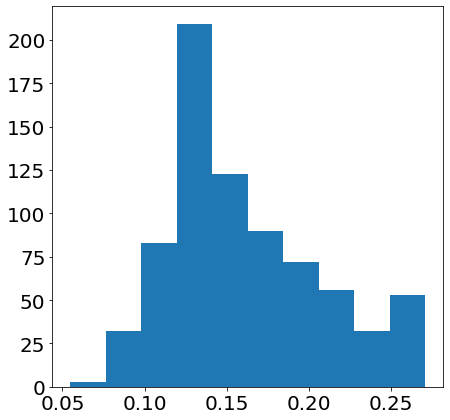

In [148]:
_ = pl.hist(df_segments['Z_DES'])

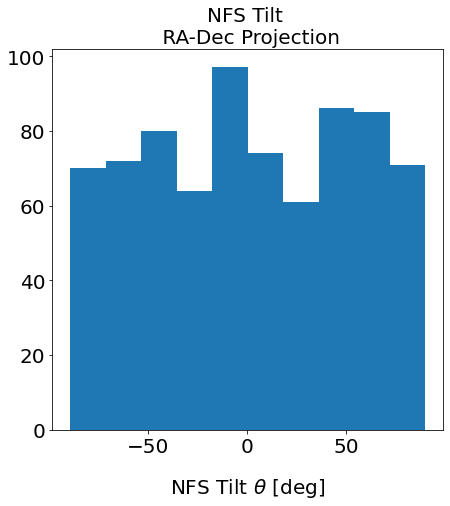

In [149]:
#- Histogram of the Tilt segments
fig = pl.figure(figsize=(7,7))
_ = pl.hist(np.array(tilt_fila_segment))
len(tilt_fila_segment)
pl.title('NFS Tilt \n RA-Dec Projection')
pl.xlabel(r'NFS Tilt $\theta$ [deg]')
pl.show()

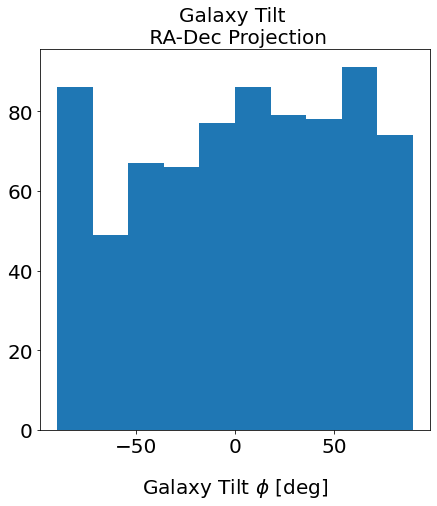

In [150]:
#- Histogram of the Galaxy inclinations
fig = pl.figure(figsize=(7,7))
_ = pl.hist(df_segments['PHI_DES'])
pl.title('Galaxy Tilt \n RA-Dec Projection')
pl.xlabel(r'Galaxy Tilt $\phi$ [deg]')
pl.show()

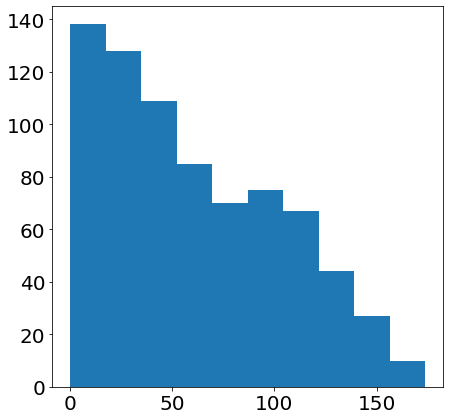

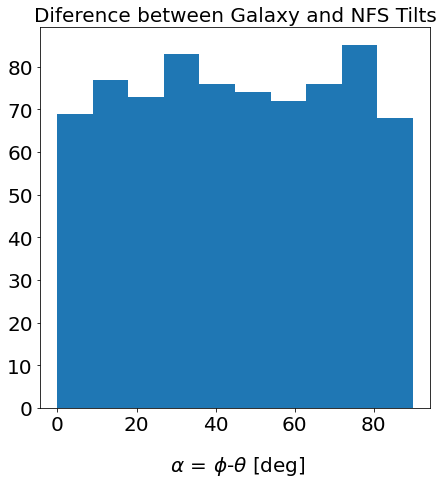

In [151]:
#- Hist of the Diference between Galaxy and Filament Segment Tilts
fig = pl.figure(figsize=(7,7))

diff = np.abs(df_segments['PHI_DES'] - df_segments['TILT_NEAREST_SEGMENT'])
# diff = (df_segments['PHI_DES'] - df_segments['TILT_NEAREST_SEGMENT'])*180/np.pi 
_= pl.hist(diff)
pl.show()

diff[diff>=90] = 180 - diff[diff>=90]
_ = pl.hist(diff)
pl.xlabel(r' $\alpha$ = $\phi$-$\theta$ [deg]')
pl.title('Diference between Galaxy and NFS Tilts')
pl.show()

In [ ]:
# diff[ii_l90]+180

14 Galaxies with alignment less than 1 deg


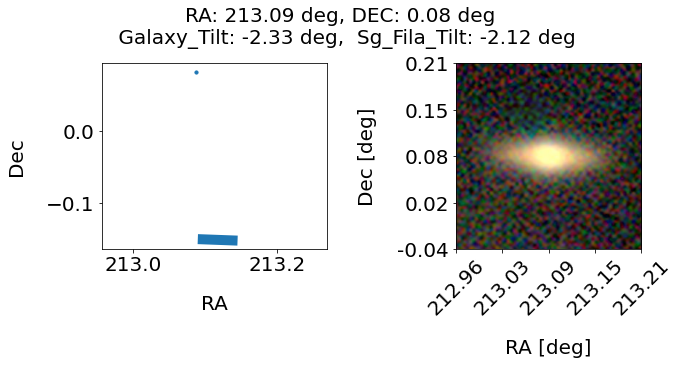

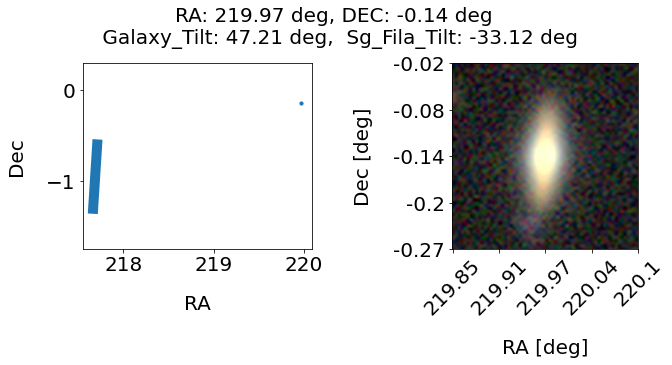

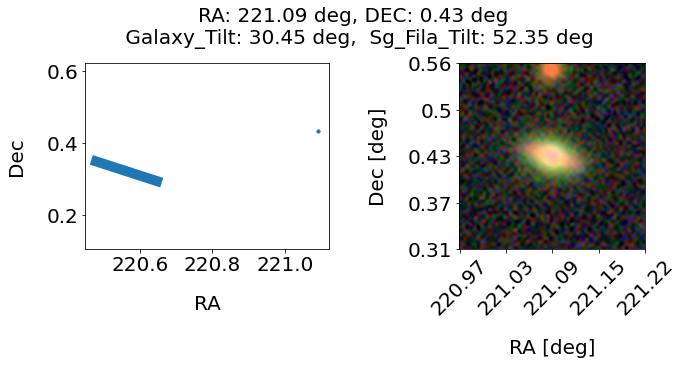

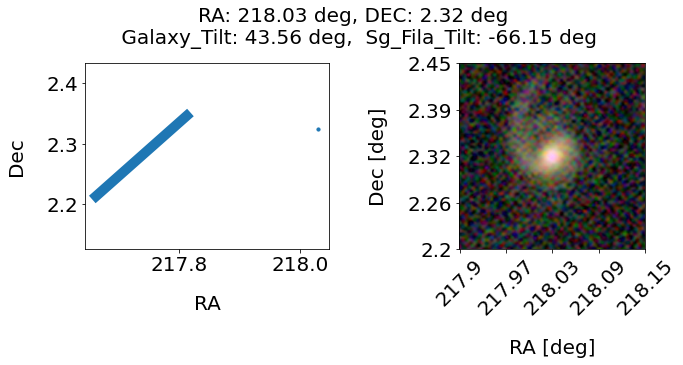

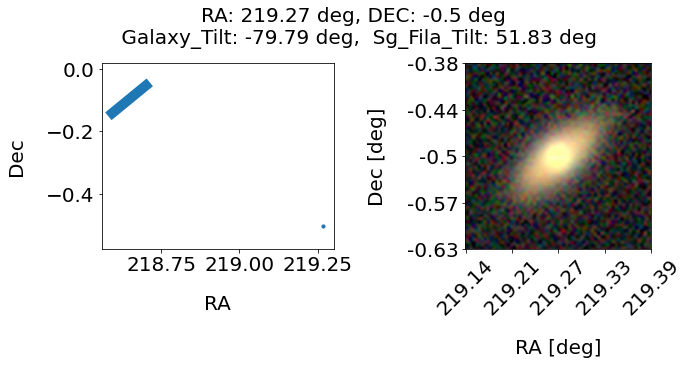

In [152]:
#- Plot some examples of Galaxies and Filamentary segments For a difference less than #degrees
lim = 1
ii_diff = (diff < lim)
ii_aligned = np.where(ii_diff == True)[0]
print(f'{len(ii_aligned)} Galaxies with alignment less than {lim} deg')

for ii_al in ii_aligned[:5]:
    fig = pl.figure(figsize=(10,5))
    
    ra__ = np.array(df_segments['RA_DES'])[ii_al]
    dec__ = np.array(df_segments['DEC_DES'])[ii_al]    
    
    pl.subplot(1,2,1)
    pl.plot(np.array(df_segments['RA_NEAREST_SEGMENT'])[ii_al], np.array(df_segments['DEC_NEAREST_SEGMENT'])[ii_al], lw=10)
    pl.scatter(ra__, dec__, s=10)
    pl.xlabel('RA')
    pl.ylabel('Dec')
    pl.axis('equal')

    url_DES = f'https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra__}&dec={dec__}&layer=ls-dr9&zoom=16'
    IMAGE_DES = load_image(url_DES)
    
    pl.subplot(1,2,2)
    pl.imshow(IMAGE_DES)    
    pl.xticks(np.linspace(0,len(IMAGE_DES[:,0]),5), np.around(np.linspace(ra__-0.125, ra__+0.125, 5), decimals=2), rotation = 45)
    pl.yticks(np.linspace(0,len(IMAGE_DES[:,0]),5), np.around(np.sort(np.linspace(dec__-0.125, dec__+0.125, 5))[::-1], decimals=2))
    pl.xlabel('RA [deg]')
    pl.ylabel('Dec [deg]')
    
    tilt_galaxy = df_segments['PHI_DES'][ii_al]
    tilt_fila = df_segments['TILT_NEAREST_SEGMENT'][ii_al]
    
    pl.suptitle(f'RA: {round(ra__,2)} deg, DEC: {round(dec__,2)} deg \n Galaxy_Tilt: {round(tilt_galaxy,2)} deg,  Sg_Fila_Tilt: {round(tilt_fila,2)} deg')
    pl.tight_layout()
    pl.show()

In [ ]:
# x = [-1,0,1]
# y = [-1,0,1]

# for i in x:
#     for j in y:
#         if not( (i==0) & (j==0)):
#             if i==0: i += 0.00000000001
#             ang = np.arctan(j/i)*180/np.pi
#             print(i,j, f'{ang:.1f}')
#             pl.plot([0,i],[0,j], label=f'{ang:.1f}')
            
# pl.axis('equal')
# pl.legend(loc=1)
# pl.show()

In [ ]:
# #- Plot unalignment galaxies
# ii_diff = (diff < 90) & (diff > 88) 
# ii_aligned = np.where(ii_diff == True)[0]
# print(f'{len(ii_aligned)} Galaxies with alignment less than {2*lim} deg')

# for ii_al in ii_aligned[:5]:
#     fig = pl.figure(figsize=(10,5))
    
#     ra__ = np.array(df_segments['RA_DES'])[ii_al]
#     dec__ = np.array(df_segments['DEC_DES'])[ii_al]    
    
#     pl.subplot(1,2,1)
#     pl.plot(np.array(df_segments['RA_NEAREST_SEGMENT'])[ii_al], np.array(df_segments['DEC_NEAREST_SEGMENT'])[ii_al], lw=10)
#     pl.scatter(ra__, dec__, s=10)
#     pl.xlabel('RA')
#     pl.ylabel('Dec')
#     pl.axis('equal')

#     url_DES = f'https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra__}&dec={dec__}&layer=ls-dr9&zoom=16'
#     IMAGE_DES = load_image(url_DES)
    
#     pl.subplot(1,2,2)
#     pl.imshow(IMAGE_DES)    
#     pl.xticks(np.linspace(0,len(IMAGE_DES[:,0]),5), np.around(np.linspace(ra__-0.125, ra__+0.125, 5), decimals=2), rotation = 45)
#     pl.yticks(np.linspace(0,len(IMAGE_DES[:,0]),5), np.around(np.sort(np.linspace(dec__-0.125, dec__+0.125, 5))[::-1], decimals=2))
#     pl.xlabel('RA [deg]')
#     pl.ylabel('Dec [deg]')
    
#     tilt_galaxy = df_segments['PHI_DES'][ii_al]
#     tilt_fila = df_segments['TILT_NEAREST_SEGMENT'][ii_al]
    
#     pl.suptitle(f'RA: {round(ra__,2)} deg, DEC: {round(dec__,2)} deg \n Galaxy_Tilt: {round(tilt_galaxy,2)} deg,  Sg_Fila_Tilt: {round(tilt_fila,2)} deg')
#     pl.tight_layout()
#     pl.show()

In [ ]:
#- Plot some examples of Galaxies and Filamentary segments For a difference less than #degrees
# ii_diff = (diff < 10*lim) & (diff > -10*lim) 
# ii_aligned = np.where(ii_diff == True)[0]
# print(f'{len(ii_aligned)} Galaxies with alignment less than {2*lim} deg')

# for ii_al in ii_aligned[:5]:
#     fig = pl.figure(figsize=(10,5))
    
#     ra__ = np.array(df_segments['RA_DES'])[ii_al]
#     dec__ = np.array(df_segments['DEC_DES'])[ii_al]    
    
#     pl.subplot(1,2,1)
#     pl.plot(np.array(df_segments['RA_NEAREST_SEGMENT'])[ii_al], np.array(df_segments['DEC_NEAREST_SEGMENT'])[ii_al], lw=10)
#     pl.scatter(ra__, dec__, s=10)
#     pl.xlabel('RA')
#     pl.ylabel('Dec')
#     pl.axis('equal')

#     url_DES = f'https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra__}&dec={dec__}&layer=ls-dr9&zoom=16'
#     IMAGE_DES = load_image(url_DES)
    
#     pl.subplot(1,2,2)
#     pl.imshow(IMAGE_DES)    
#     pl.xticks(np.linspace(0,len(IMAGE_DES[:,0]),5), np.around(np.linspace(ra__-0.125, ra__+0.125, 5), decimals=2), rotation = 45)
#     pl.yticks(np.linspace(0,len(IMAGE_DES[:,0]),5), np.around(np.sort(np.linspace(dec__-0.125, dec__+0.125, 5))[::-1], decimals=2))
#     pl.xlabel('RA [deg]')
#     pl.ylabel('Dec [deg]')
    
#     tilt_galaxy = df_segments['PHI_DES'][ii_al]
#     tilt_fila = df_segments['TILT_NEAREST_SEGMENT'][ii_al]
    
#     pl.suptitle(f'RA: {round(ra__,2)} deg, DEC: {round(dec__,2)} deg \n Galaxy_Tilt: {round(tilt_galaxy,2)} deg,  Sg_Fila_Tilt: {round(tilt_fila,2)} deg')
#     pl.tight_layout()
#     pl.show()

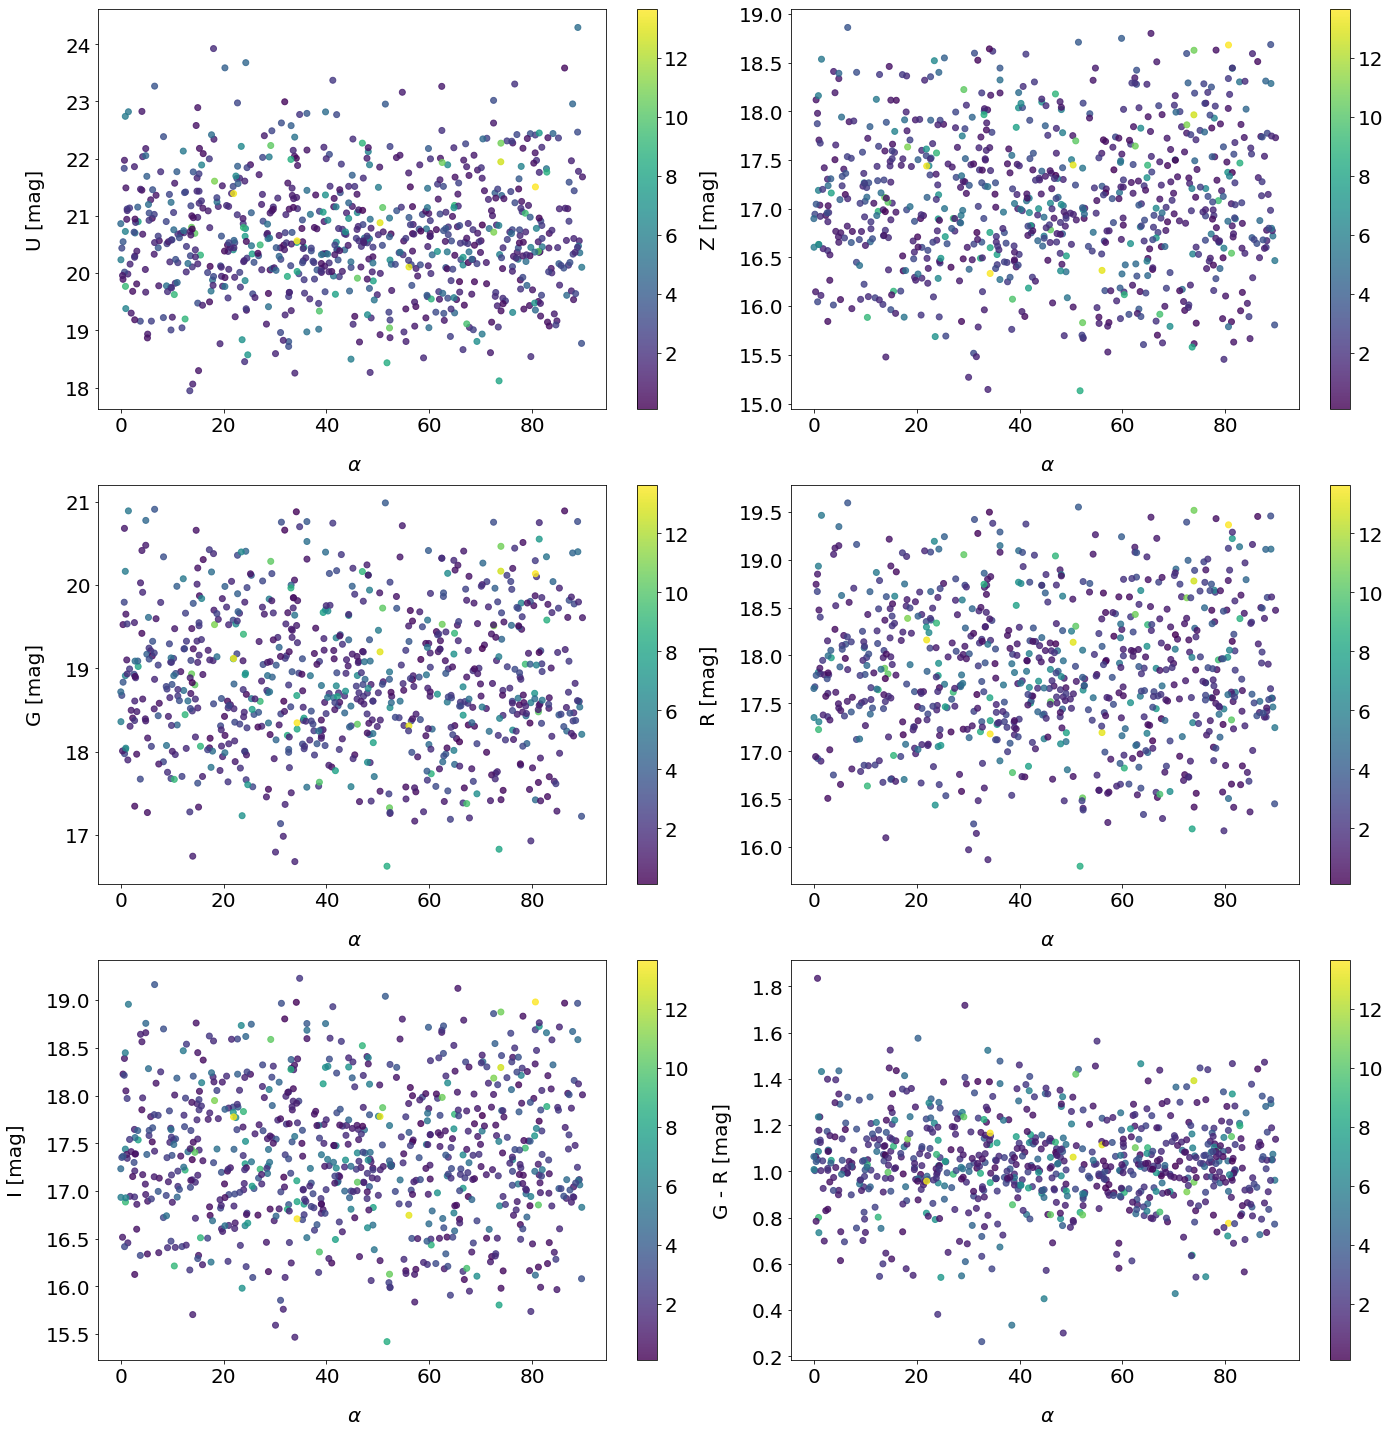

In [153]:
ii_ali = df_segments['Z_DES'] < 1

fig = pl.figure(figsize=(20,20))
pl.subplot(3,2,1)
_ = pl.scatter(diff[ii_ali], df_segments['UMAG'][ii_ali], alpha=0.8, c=df_segments['DISTANCE_NEAREST_SEGMENT'][ii_ali])
pl.colorbar()
pl.xlabel(r' $\alpha$')
pl.ylabel(r'U [mag]')

pl.subplot(3,2,2)
_ = pl.scatter(diff[ii_ali], df_segments['ZMAG'][ii_ali], alpha=0.8, c=df_segments['DISTANCE_NEAREST_SEGMENT'][ii_ali])
pl.colorbar()
pl.xlabel(r' $\alpha$')
pl.ylabel(r'Z [mag]')

pl.subplot(3,2,3)
_ = pl.scatter(diff[ii_ali], df_segments['GMAG'][ii_ali], alpha=0.8, c=df_segments['DISTANCE_NEAREST_SEGMENT'][ii_ali])
pl.colorbar()
pl.xlabel(r' $\alpha$')
pl.ylabel(r'G [mag]')

pl.subplot(3,2,4)
_ = pl.scatter(diff[ii_ali], df_segments['RMAG'][ii_ali], alpha=0.8, c=df_segments['DISTANCE_NEAREST_SEGMENT'][ii_ali])
pl.colorbar()
pl.xlabel(r' $\alpha$')
pl.ylabel(r'R [mag]')

pl.subplot(3,2,5)
_ = pl.scatter(diff[ii_ali], df_segments['IMAG'][ii_ali], alpha=0.8, c=df_segments['DISTANCE_NEAREST_SEGMENT'][ii_ali])
pl.colorbar()
pl.xlabel(r' $\alpha$')
pl.ylabel(r'I [mag]')

pl.subplot(3,2,6)
_ = pl.scatter(diff[ii_ali], df_segments['GMAG'][ii_ali] - df_segments['RMAG'][ii_ali], alpha=0.8, c=df_segments['DISTANCE_NEAREST_SEGMENT'][ii_ali])
pl.colorbar()
pl.xlabel(r' $\alpha$')
pl.ylabel(r'G - R [mag]')

pl.tight_layout()
fig.tight_layout()
pl.show()

Text(0, 0.5, 'Distance to NSF')

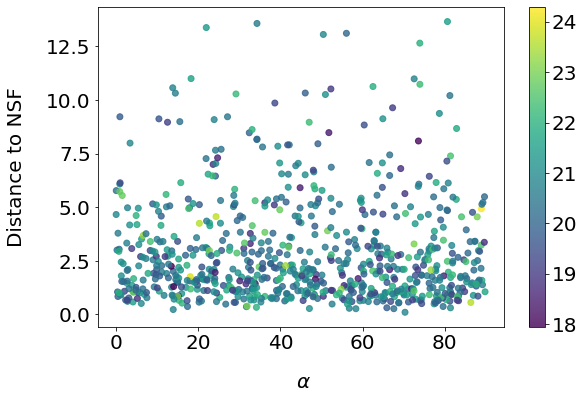

In [154]:
ii_ali = diff < 100

fig = pl.figure(figsize=(20,20))
pl.subplot(3,2,1)
_ = pl.scatter(diff[ii_ali], df_segments['DISTANCE_NEAREST_SEGMENT'][ii_ali], alpha=0.8, c=df_segments['UMAG'][ii_ali])
pl.colorbar()
pl.xlabel(r' $\alpha$')
pl.ylabel(r'Distance to NSF')

# pl.subplot(3,2,2)
# _ = pl.scatter(diff[ii_ali], df_segments['ZMAG'][ii_ali], alpha=0.8, c=df_segments['DISTANCE_NEAREST_SEGMENT'][ii_ali])
# pl.colorbar()
# pl.xlabel(r' $\alpha$')
# pl.ylabel(r'Z [mag]')

# pl.subplot(3,2,3)
# _ = pl.scatter(diff[ii_ali], df_segments['GMAG'][ii_ali], alpha=0.8, c=df_segments['DISTANCE_NEAREST_SEGMENT'][ii_ali])
# pl.colorbar()
# pl.xlabel(r' $\alpha$')
# pl.ylabel(r'G [mag]')

# pl.subplot(3,2,4)
# _ = pl.scatter(diff[ii_ali], df_segments['RMAG'][ii_ali], alpha=0.8, c=df_segments['DISTANCE_NEAREST_SEGMENT'][ii_ali])
# pl.colorbar()
# pl.xlabel(r' $\alpha$')
# pl.ylabel(r'R [mag]')

# pl.subplot(3,2,5)
# _ = pl.scatter(diff[ii_ali], df_segments['IMAG'][ii_ali], alpha=0.8, c=df_segments['DISTANCE_NEAREST_SEGMENT'][ii_ali])
# pl.colorbar()
# pl.xlabel(r' $\alpha$')
# pl.ylabel(r'I [mag]')

# pl.subplot(3,2,6)
# _ = pl.scatter(diff[ii_ali], df_segments['GMAG'][ii_ali] - df_segments['RMAG'][ii_ali], alpha=0.8, c=df_segments['DISTANCE_NEAREST_SEGMENT'][ii_ali])
# pl.colorbar()
# pl.xlabel(r' $\alpha$')
# pl.ylabel(r'G - R [mag]')

# pl.tight_layout()
# fig.tight_layout()
# pl.show()

Text(0, 0.5, 'Z')

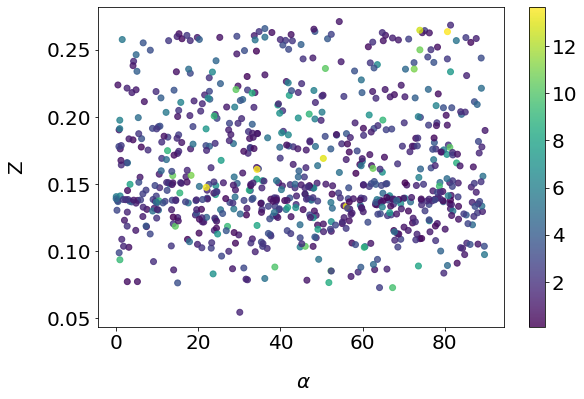

In [155]:
fig = pl.figure(figsize=(20,20))
pl.subplot(3,2,1)
_ = pl.scatter(diff, df_segments['Z_GAMA'], alpha=0.8, c=df_segments['DISTANCE_NEAREST_SEGMENT'])
pl.colorbar()
pl.xlabel(r' $\alpha$')
pl.ylabel(r'Z')

Text(0, 0.5, ' Distance to NSF')

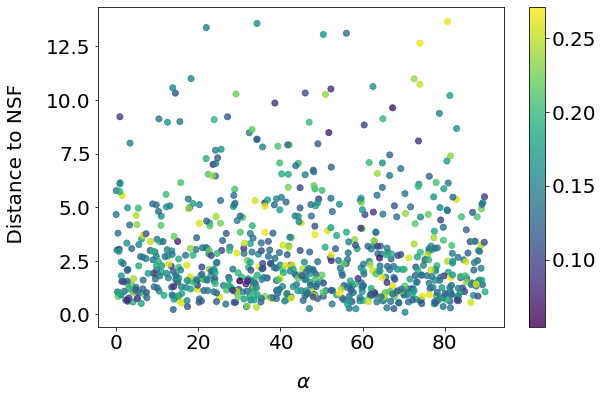

In [156]:
fig = pl.figure(figsize=(20,20))
pl.subplot(3,2,1)
_ = pl.scatter(diff, df_segments['DISTANCE_NEAREST_SEGMENT'], alpha=0.8, c=df_segments['Z_GAMA'])
pl.colorbar()
pl.xlabel(r' $\alpha$')
pl.ylabel(r' Distance to NSF')

Text(0, 0.5, ' Distance to NSF')

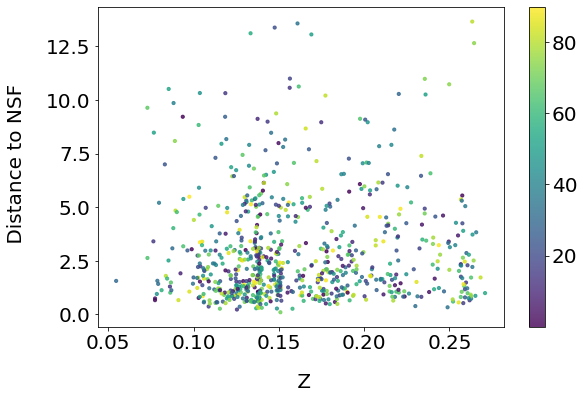

In [157]:
fig = pl.figure(figsize=(20,20))
pl.subplot(3,2,1)
_ = pl.scatter(df_segments['Z_GAMA'], df_segments['DISTANCE_NEAREST_SEGMENT'], alpha=0.8, c=diff, s=10)
pl.colorbar()
pl.xlabel(r' Z')
pl.ylabel(r' Distance to NSF')